<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [184]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

Load Data

In [185]:
# Load the data
house = pd.read_csv('./housing.csv')

In [186]:
# A:
house.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [187]:
house.shape

(1460, 81)

In [188]:
## Remove any houses that are not residential from the dataset (MSZoning col)
house = house[house['MSZoning'] != 'C (all)']

In [189]:
house.shape

(1450, 81)

The dataset has 81 columns including 81 features and 1450 observations

In [190]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [191]:
#split fixed features and dynamic features,
#also drop ID

fixed_features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
                  'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                  'Alley', 'MiscFeature',
                  'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType','HouseStyle', 
                  'YearBuilt',
                  'MasVnrType','MasVnrArea', 
                  'Foundation', 
                  'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 
                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','GrLivArea', 
                  'BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                  'TotRmsAbvGrd', 'Functional',
                  'GarageType','GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 
                  'PavedDrive', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                  'MiscVal', 'PoolArea',  
                  'MoSold', 'YrSold', 'SaleType','SaleCondition', 'SalePrice']

dynamic_features = ['OverallQual', 'OverallCond', 'YearRemodAdd','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 
          'Heating','HeatingQC', 'CentralAir', 'Electrical','LowQualFinSF', 'KitchenQual', 'Fireplaces', 'FireplaceQu',
         'GarageQual', 'GarageCond','BsmtQual','BsmtCond', 'Fence','PoolQC','SalePrice']

In [192]:
print(len(fixed_features))
print(len(dynamic_features))

57
24


EDA - cleaning and imputing missing data

In [193]:
df1 = house[fixed_features]
df1.shape

(1450, 57)

In [194]:
df1.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
Alley             object
MiscFeature       object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
YearBuilt          int64
MasVnrType        object
MasVnrArea       float64
Foundation        object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Functional        object
GarageType        object


Drop columns with too many null values

In [195]:
df1.isnull().sum().sort_values(ascending=False)

MiscFeature      1398
Alley            1361
LotFrontage       259
GarageFinish       79
GarageType         79
GarageYrBlt        79
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
MasVnrType          8
MasVnrArea          8
Foundation          0
BsmtFinSF1          0
YearBuilt           0
HouseStyle          0
BldgType            0
Condition2          0
SalePrice           0
BsmtUnfSF           0
Condition1          0
Neighborhood        0
LandSlope           0
LotConfig           0
Utilities           0
LandContour         0
LotShape            0
Street              0
LotArea             0
MSZoning            0
BsmtFinSF2          0
1stFlrSF            0
TotalBsmtSF         0
SaleCondition       0
SaleType            0
YrSold              0
MoSold              0
PoolArea            0
MiscVal             0
ScreenPorch         0
3SsnPorch           0
EnclosedPorch       0
OpenPorchSF         0
WoodDeckSF          0
PavedDrive          0
GarageArea          0
GarageCars

In [196]:
# Dropping columns having >1100 null values (Alley, MiscFeature)
df1.drop('Alley', axis =1, inplace = True)
df1.drop('MiscFeature', axis =1, inplace = True)

C:\Users\haden\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [197]:
# Some of the columns are not features of a house, then I also drop them
# 'Utilities', 'SaleType', 'SaleCondition'
df1.drop(['Utilities', 'SaleType', 'SaleCondition'], axis=1, inplace=True)

In [198]:
df1.shape

(1450, 52)

imputing missing data for other columns with missung value

In [199]:
# numerical features, replace with 0
df1["LotFrontage"] = df1.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
df1["GarageYrBlt"]=df1["GarageYrBlt"].fillna(0)
df1["MasVnrArea"]= df1["GarageYrBlt"].fillna(0)

C:\Users\haden\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\haden\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\haden\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [200]:
# categorical feartures, replace with 'None'
df1.GarageFinish.fillna('None', inplace = True)
df1.GarageType.fillna('None', inplace = True)
df1.BsmtExposure.fillna('None', inplace = True)
df1.BsmtFinType2.fillna('None', inplace = True)
df1.BsmtFinType1.fillna('None', inplace = True)
df1.MasVnrType.fillna('None', inplace = True)

C:\Users\haden\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [201]:
#checking if any null value exists
df1.isnull().sum().max()

0

Drop columns with low variance (one feature accounts for majority of the values (above 95% of rows))

In [202]:
def select_feature(df, col):
    max_count = df[col].value_counts().max()
    return float(max_count)/df.shape[0]

In [203]:
feature_props = [[col,select_feature(df1, col)] for col in df1.columns]
feature_props = pd.DataFrame(feature_props, columns=['feature','majority'])
feature_props_remove_cols = feature_props[feature_props.majority > 0.95].feature.values

In [204]:
print(feature_props_remove_cols)

['Street' 'Condition2' 'KitchenAbvGr' '3SsnPorch' 'MiscVal' 'PoolArea']


In [205]:
new_df1 = df1.drop(feature_props_remove_cols, axis=1)

In [206]:
new_df1.shape

(1450, 46)

Adding one more important feature:

Since area related features are very important to determine house prices, I add one more feature which is the total area of basement, first and second floor areas of each house

In [207]:
new_df1['TotalSF'] = new_df1['TotalBsmtSF'] + new_df1['1stFlrSF'] + new_df1['2ndFlrSF']

In [208]:
new_df1.shape

(1450, 47)

In [209]:
new_df1.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'YearBuilt', 'MasVnrType', 'MasVnrArea',
       'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Functional', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold',
       'YrSold', 'SalePrice', 'TotalSF'],
      dtype='object')

Other EDAs

Target Variable y: SalePrice

In [210]:
new_df1['SalePrice'].describe()

count      1450.000000
mean     181654.942069
std       79176.485241
min       37900.000000
25%      130000.000000
50%      163945.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

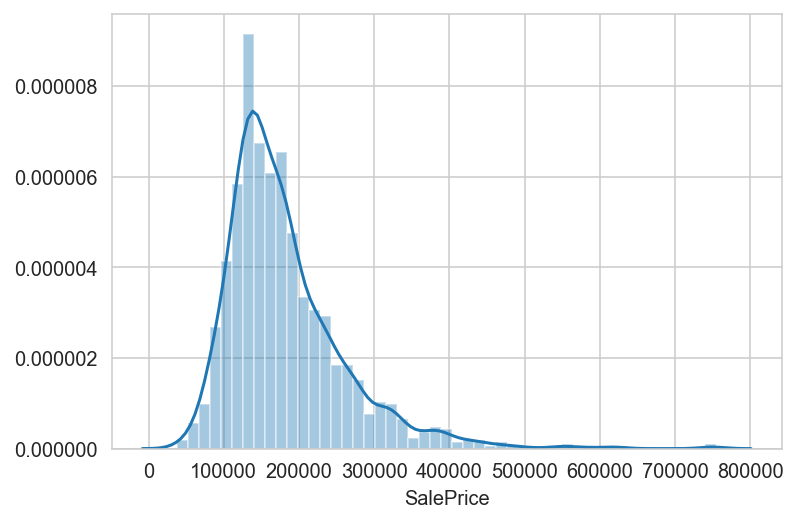

In [211]:
#histogram
sns.distplot(new_df1['SalePrice'])

The histogram shows that:

The target variable is right skewed, not follow the normal distrubution. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

In [212]:
new_df1["SalePrice_log"] = np.log1p(new_df1["SalePrice"])

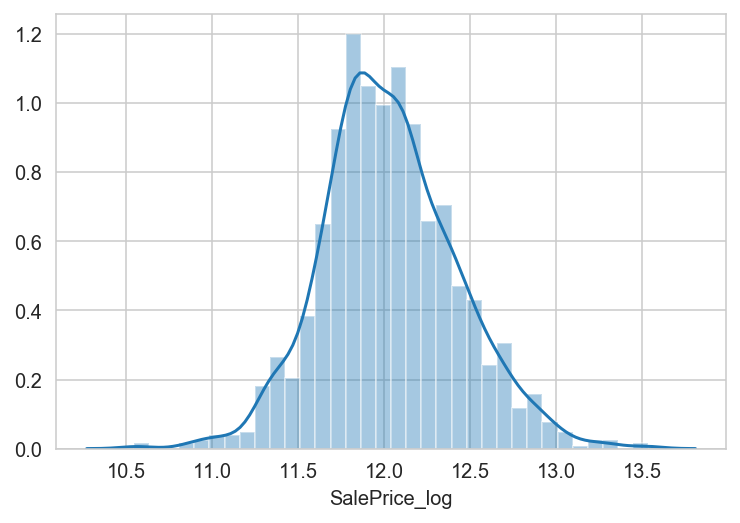

In [213]:
from scipy.stats import norm, skew
sns.distplot(new_df1['SalePrice_log']);

In [214]:
new_df1['SalePrice_log']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice_log, Length: 1450, dtype: float64

Correlation Analysis

Correlation between SalePricewith numerical features

In [215]:
corr = new_df1.corr()
corr.sort_values(['SalePrice_log'], ascending=False, inplace=True)
corr = corr.SalePrice
display(corr)

SalePrice_log    0.952050
SalePrice        1.000000
TotalSF          0.781701
GrLivArea        0.708658
GarageCars       0.642135
GarageArea       0.629831
TotalBsmtSF      0.612088
1stFlrSF         0.603300
FullBath         0.556674
YearBuilt        0.517602
TotRmsAbvGrd     0.533355
BsmtFinSF1       0.384475
LotFrontage      0.352605
OpenPorchSF      0.329491
GarageYrBlt      0.258923
MasVnrArea       0.258923
WoodDeckSF       0.320770
2ndFlrSF         0.319774
HalfBath         0.280882
LotArea          0.264715
BsmtFullBath     0.224054
BsmtUnfSF        0.216152
BedroomAbvGr     0.162008
ScreenPorch      0.110540
MoSold           0.051987
BsmtFinSF2      -0.014145
BsmtHalfBath    -0.017561
YrSold          -0.025391
MSSubClass      -0.087487
EnclosedPorch   -0.120765
Name: SalePrice, dtype: float64

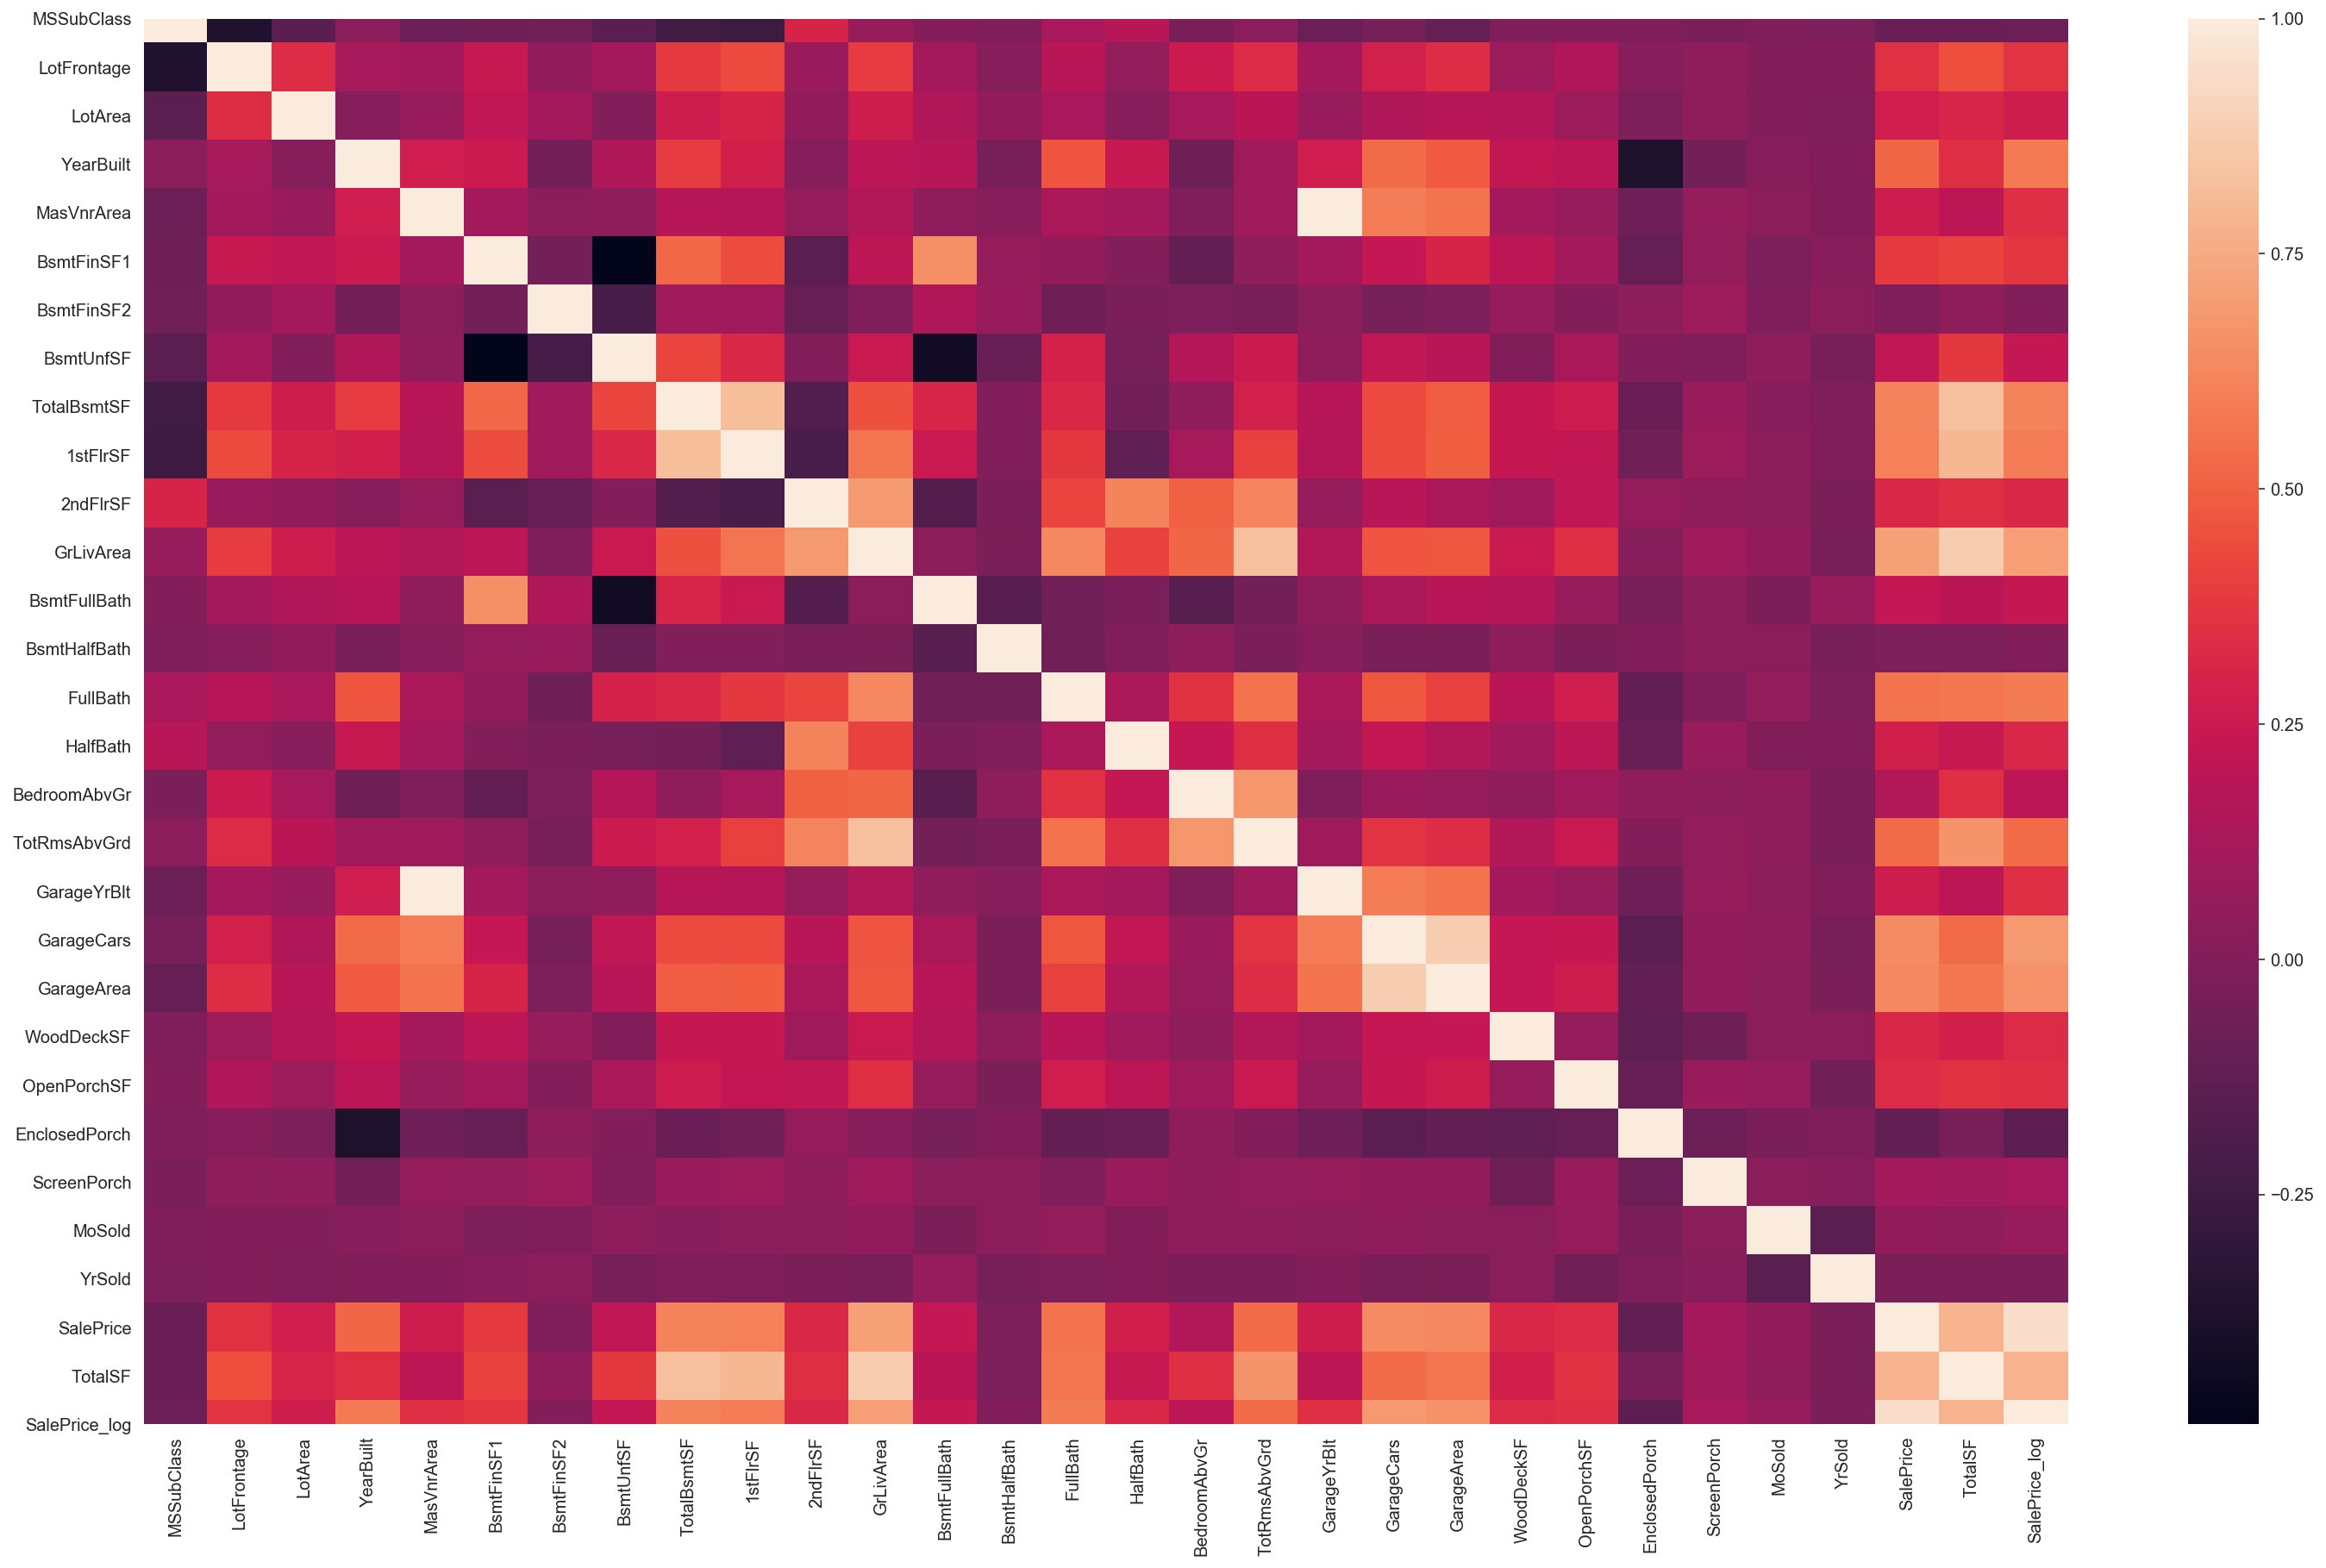

In [216]:
# correlation matrix
corrmat = new_df1.corr()
f, ax = plt.subplots(figsize=(25,15))
sns.heatmap(corrmat)

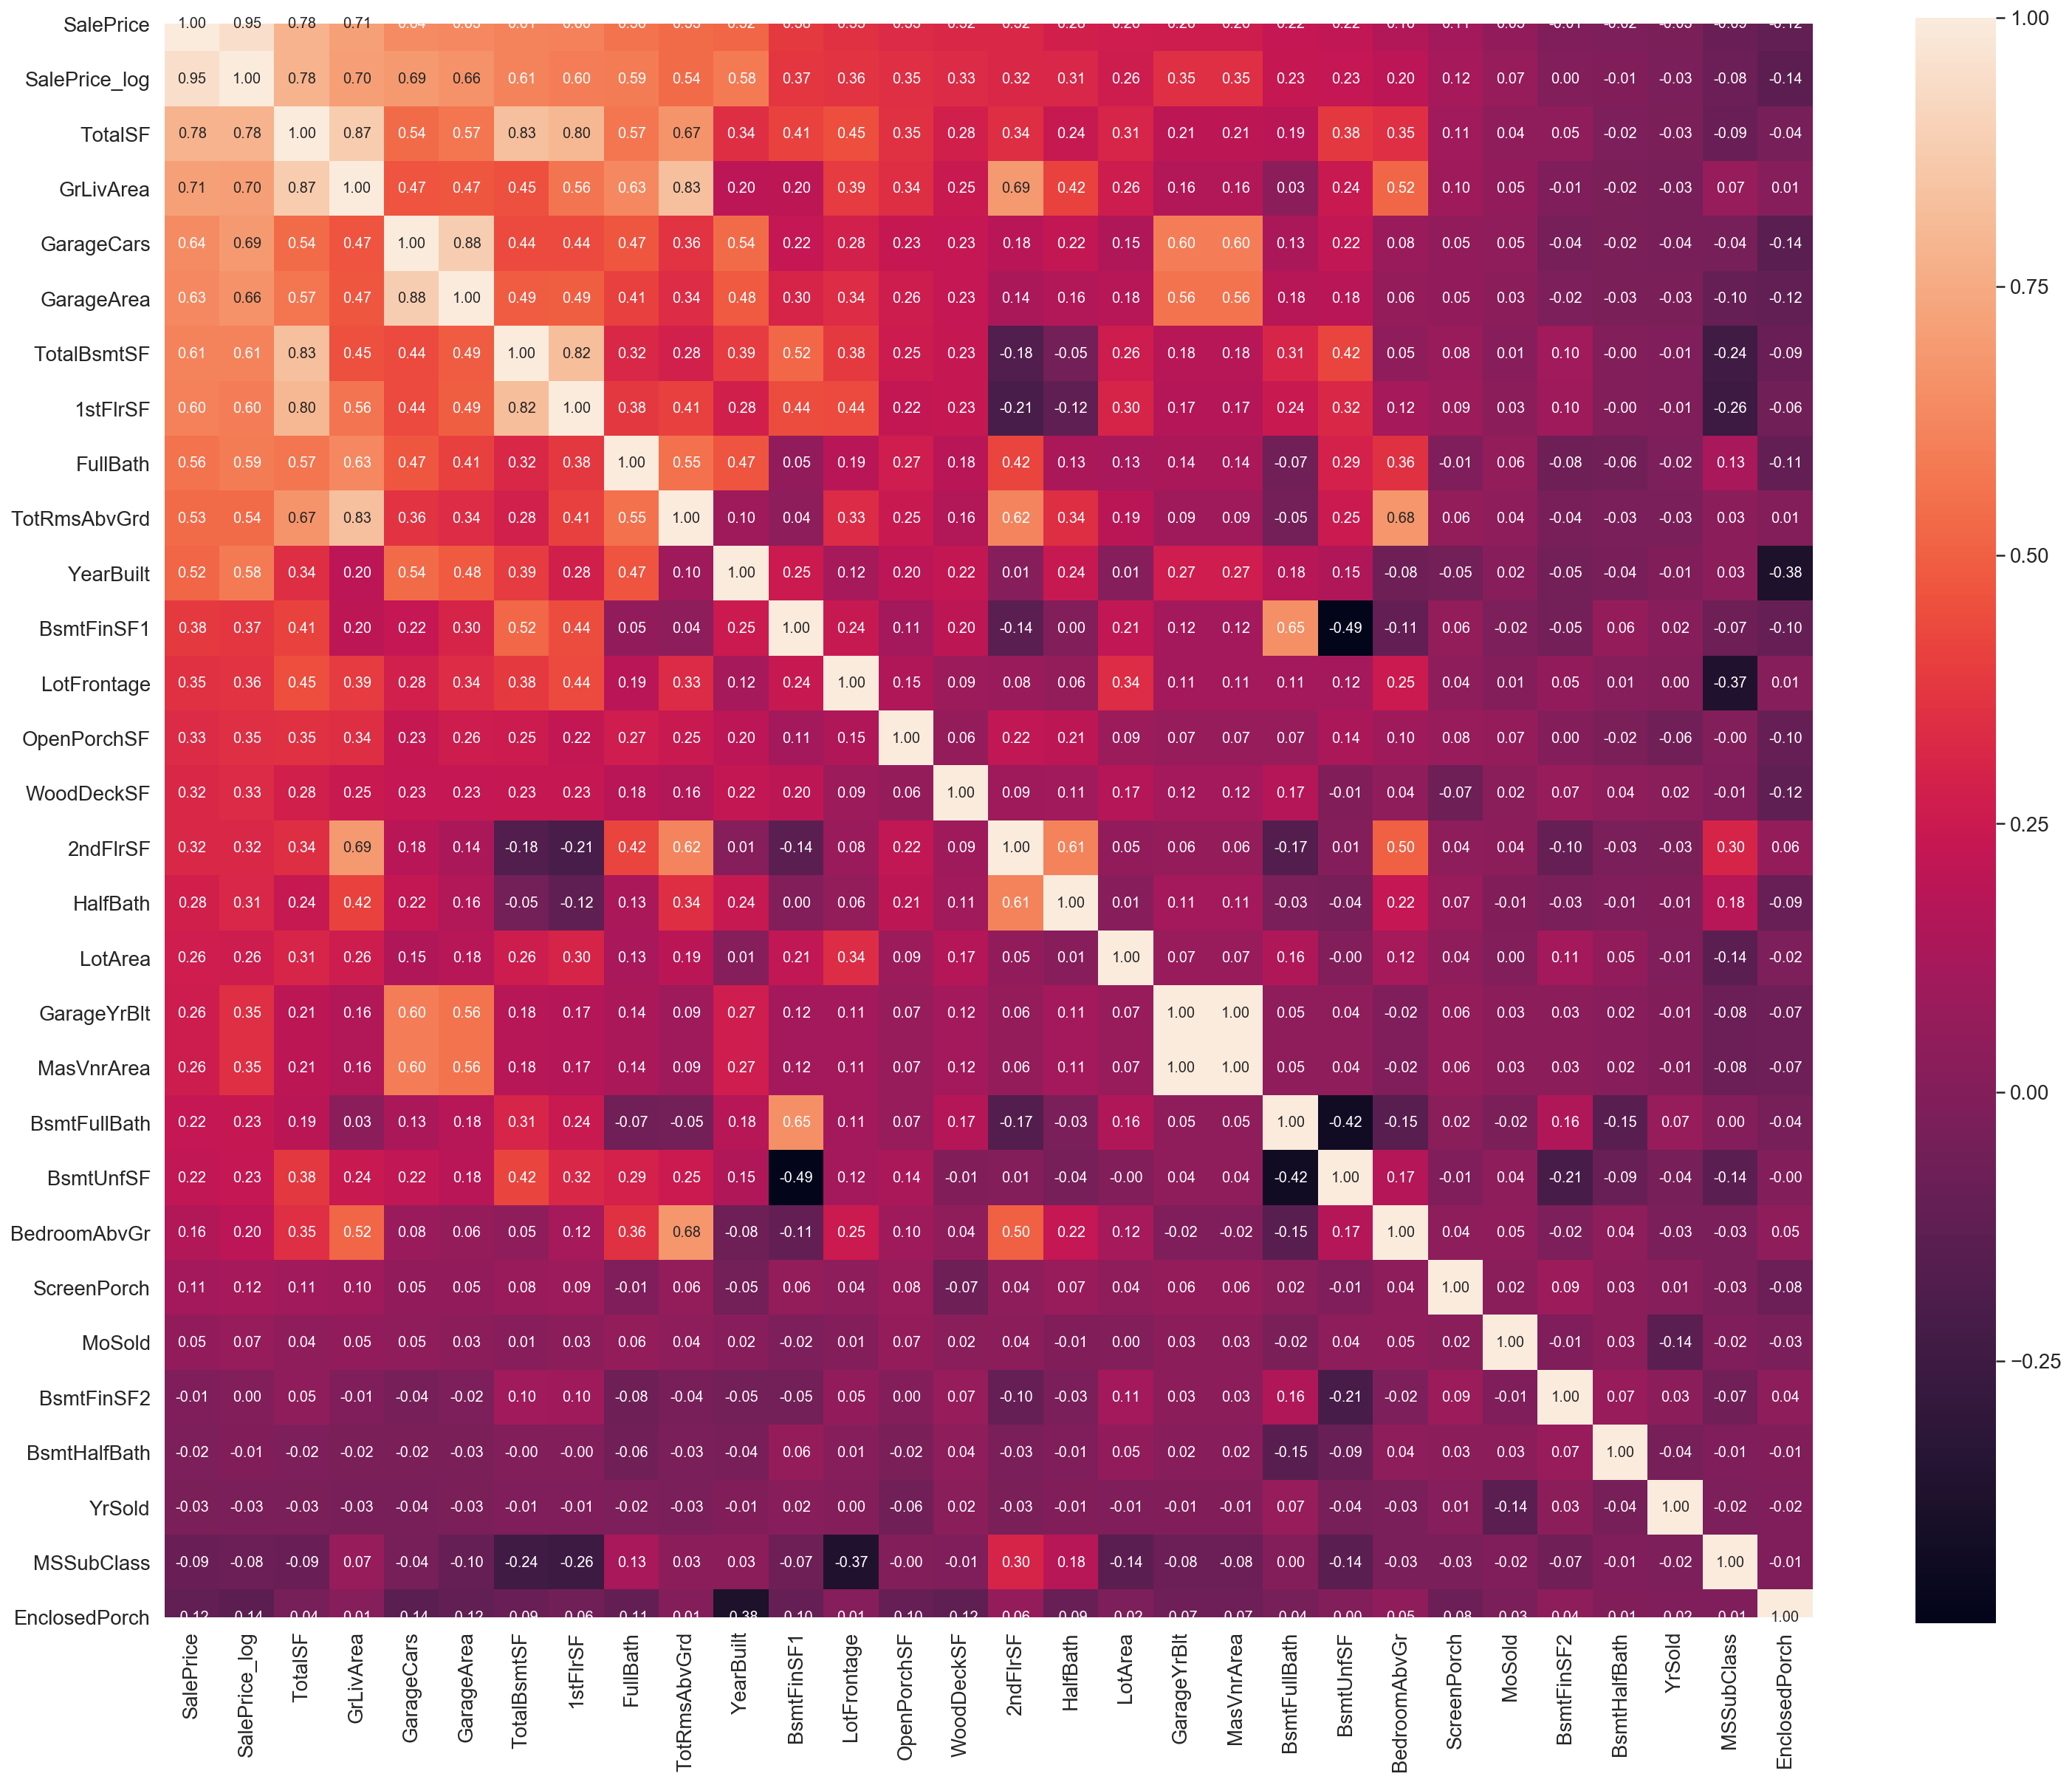

In [217]:
# correlation matrix with the top-30
corr = new_df1.corr()
k = 30
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(new_df1[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(25,20))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Summary of corrleation

1. 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables (0.88). However, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. Therefore, we just need one of these variables in our model. I keep 'GarageCars' since its correlation with 'SalePrice' is higher.
2. 'TotRmsAbvGrd' and 'GrLivArea', twin brothers again (0.83). I drop 'TotRmsAbvGrd' and 'BedroomAbvGr'
3. '1stFlrSF' and 'TotalBsmtSF' are also strongly corralated variables (0.82). We drop '1stFlrSF'
4. '2ndFlrSF' and 'GrLivArea' (0.69). I drop '2ndFlrSF'

Remove following features:

1. 'GarageArea'
2. 'TotRmsAbvGrd'
3. '1stFlrSF'
4. '2ndFlrSF'
5. 'BedroomAbvGr'
6. 'GarageYrBlt' (0.60 with 'GarageCars')
7. 'BsmtFullBath' (0.65 with 'BsmtFinSF1')

In [218]:
new_df1.drop(['GarageArea','TotRmsAbvGrd','1stFlrSF','2ndFlrSF','BedroomAbvGr',
              'GarageYrBlt','BsmtFullBath'], axis =1, inplace = True)

In [219]:
new_df1.shape

(1450, 41)

In [220]:
df1_dummies= pd.get_dummies(new_df1)
print(df1_dummies.shape)

(1450, 140)



Plotting the correlation between the target SalePrice with some of the most correlated features: GrLivArea, GarageCars, TotalBsmtSF, Foundation, and Neighborhood

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


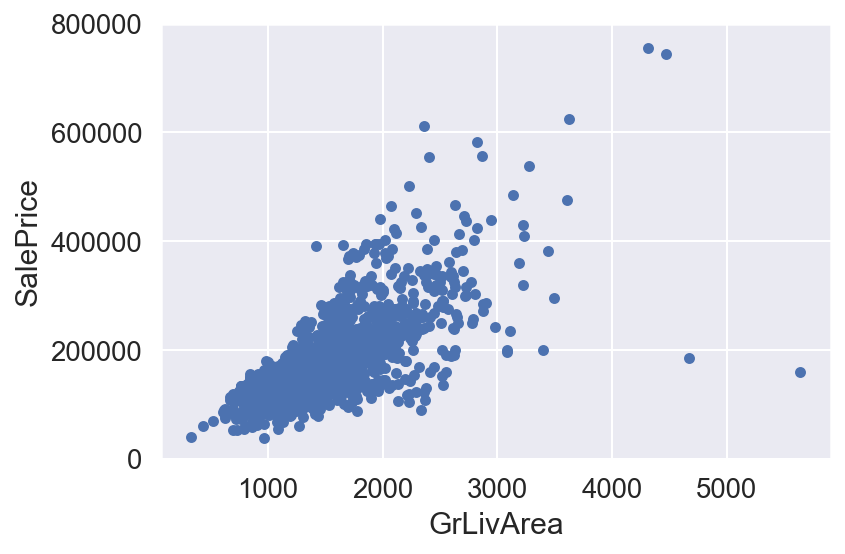

In [221]:
#scatter plot GrLivArea, the SalePrice before using log
var = 'GrLivArea'
saleprice_GarageCars = pd.concat([df1['SalePrice'], df1[var]], axis=1)
saleprice_GarageCars.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


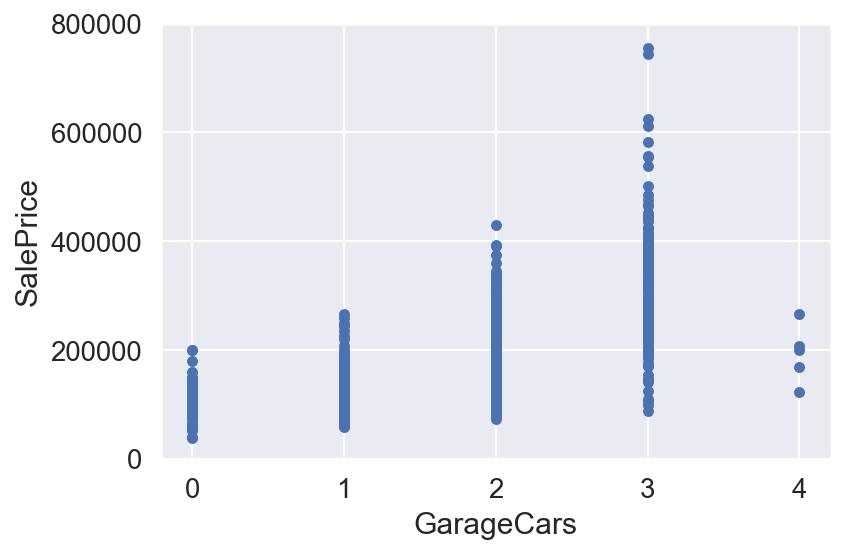

In [222]:
#scatter plot GarageCars 
var = 'GarageCars'
saleprice_GarageCars = pd.concat([df1['SalePrice'], df1[var]], axis=1)
saleprice_GarageCars.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


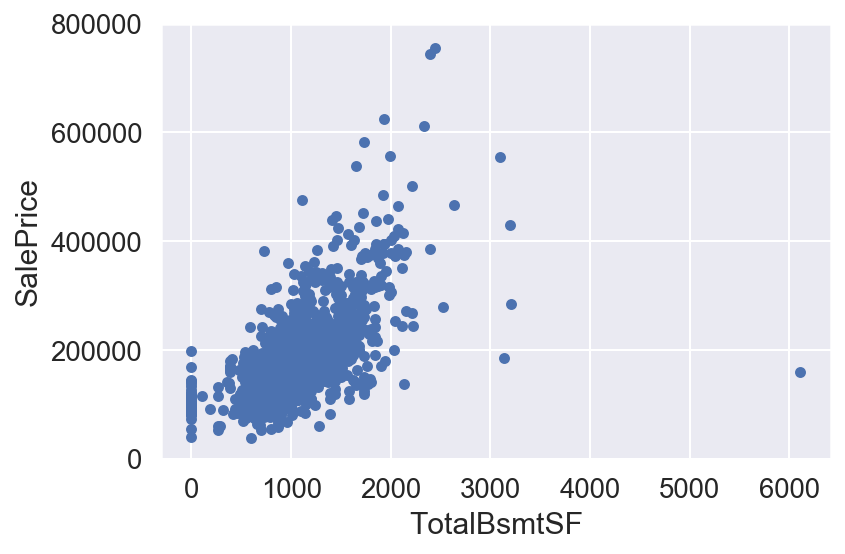

In [223]:
#scatter plot TotalBsmtSF (Total square feet of basement area)
var = 'TotalBsmtSF'
saleprice_totalBsmtSF = pd.concat([df1['SalePrice'], df1[var]], axis=1)
saleprice_totalBsmtSF.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

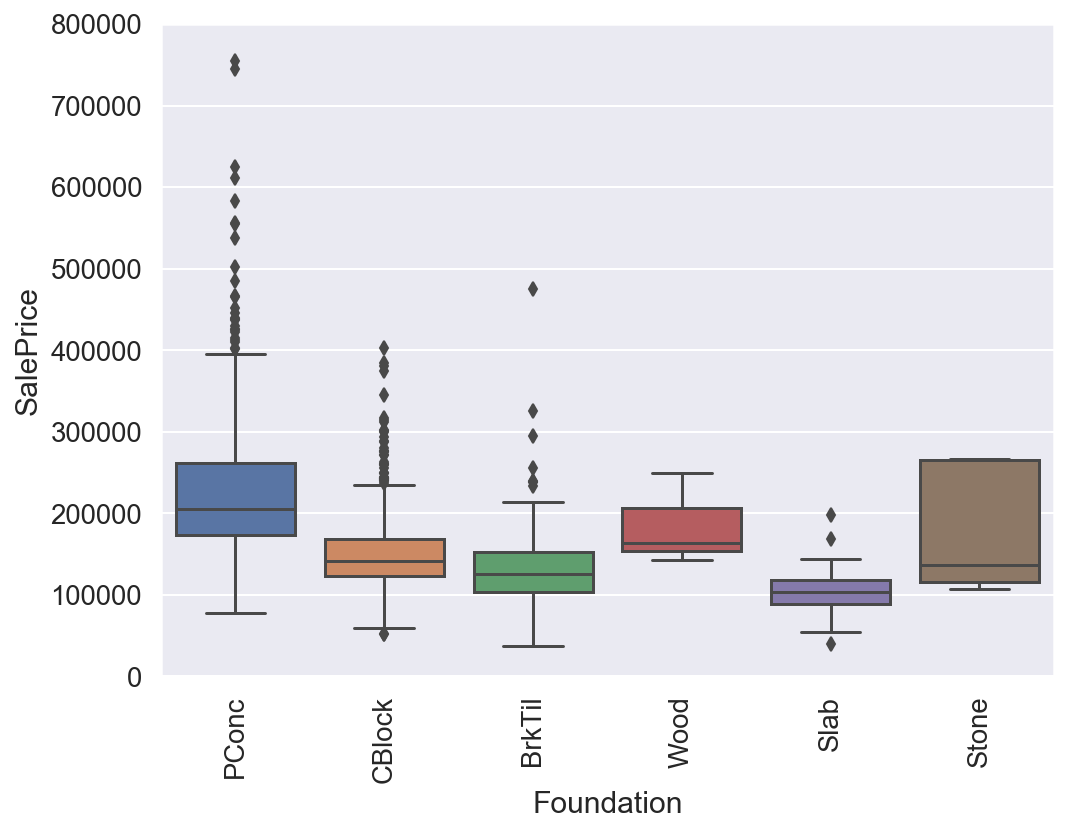

In [224]:
#box plot Foundation
var = 'Foundation'
saleprice_foudation = pd.concat([df1['SalePrice'], df1[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=saleprice_foudation)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

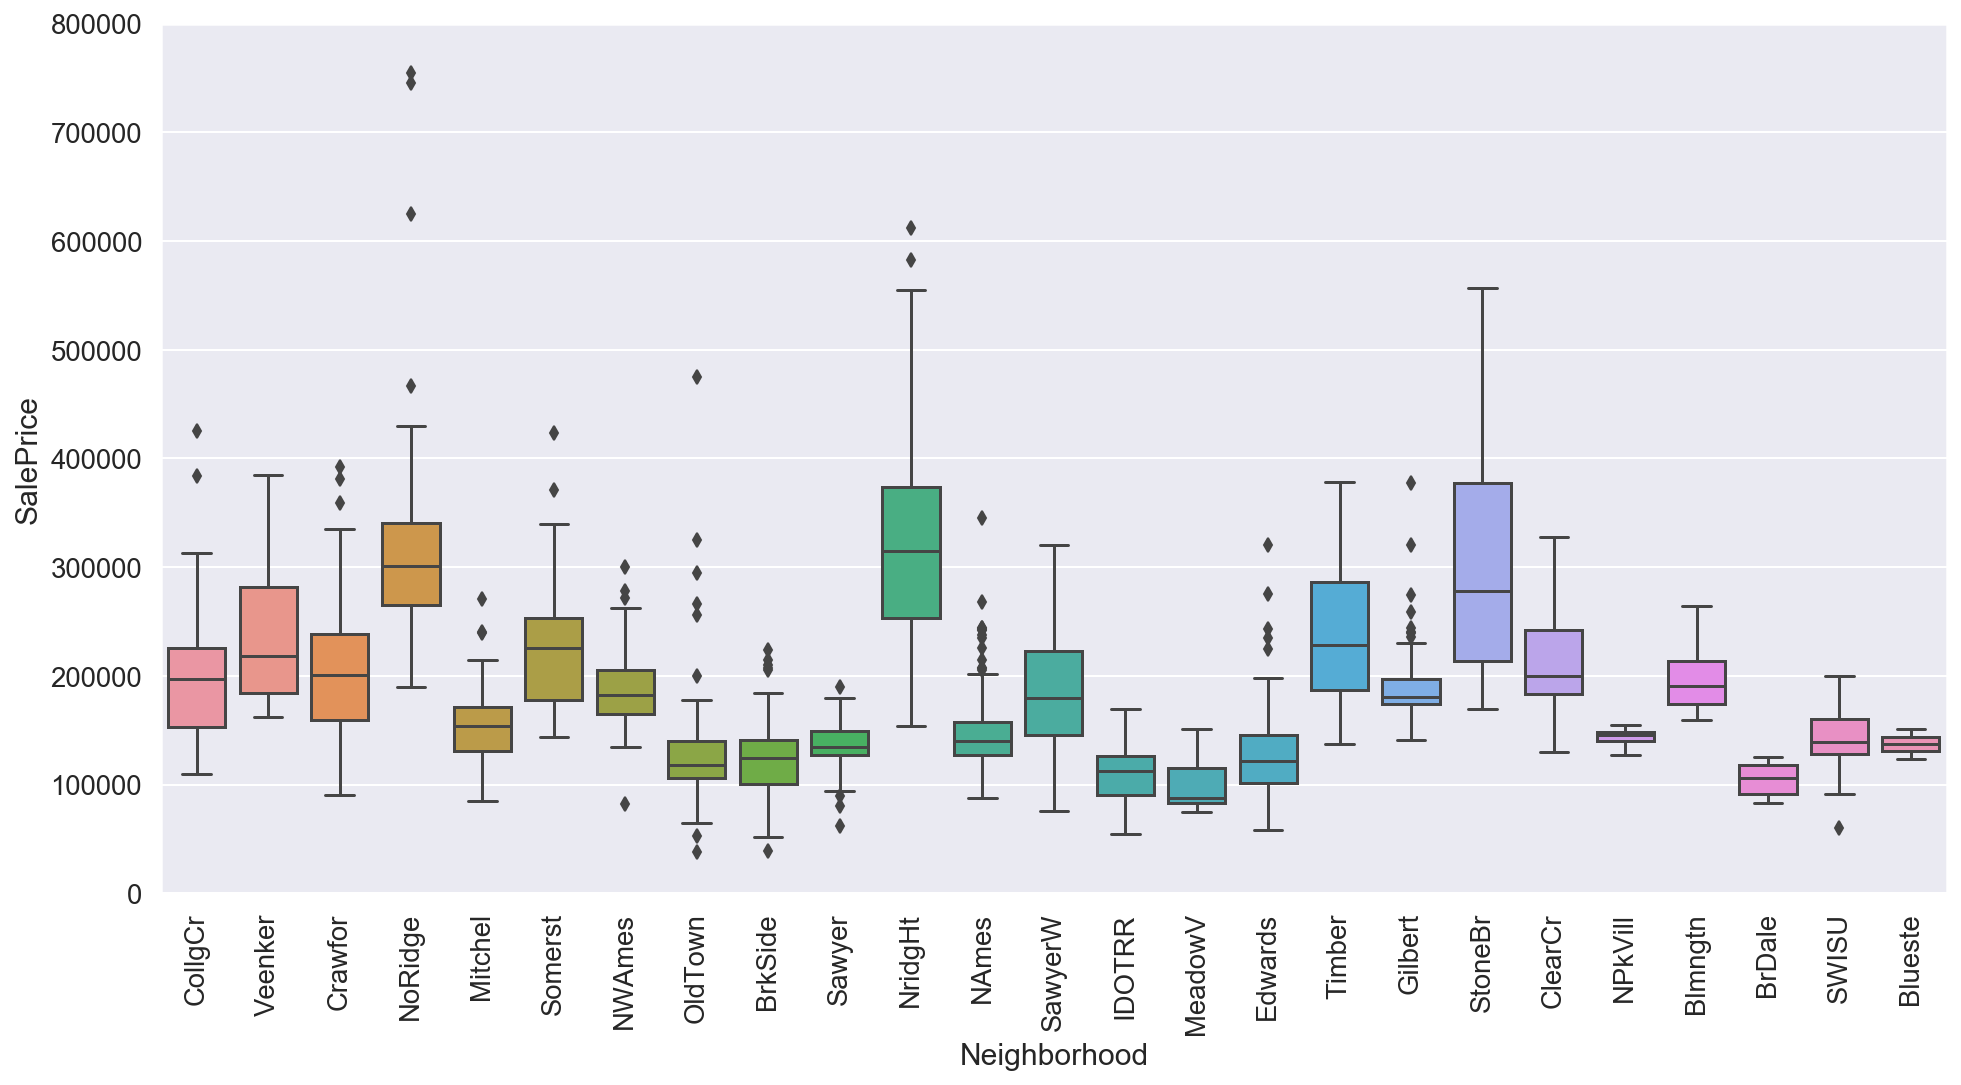

In [225]:
#box plot Neighborhood
var = 'Neighborhood'
saleprice_Neighborhood = pd.concat([df1['SalePrice'], df1[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=saleprice_Neighborhood)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

C:\Users\haden\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


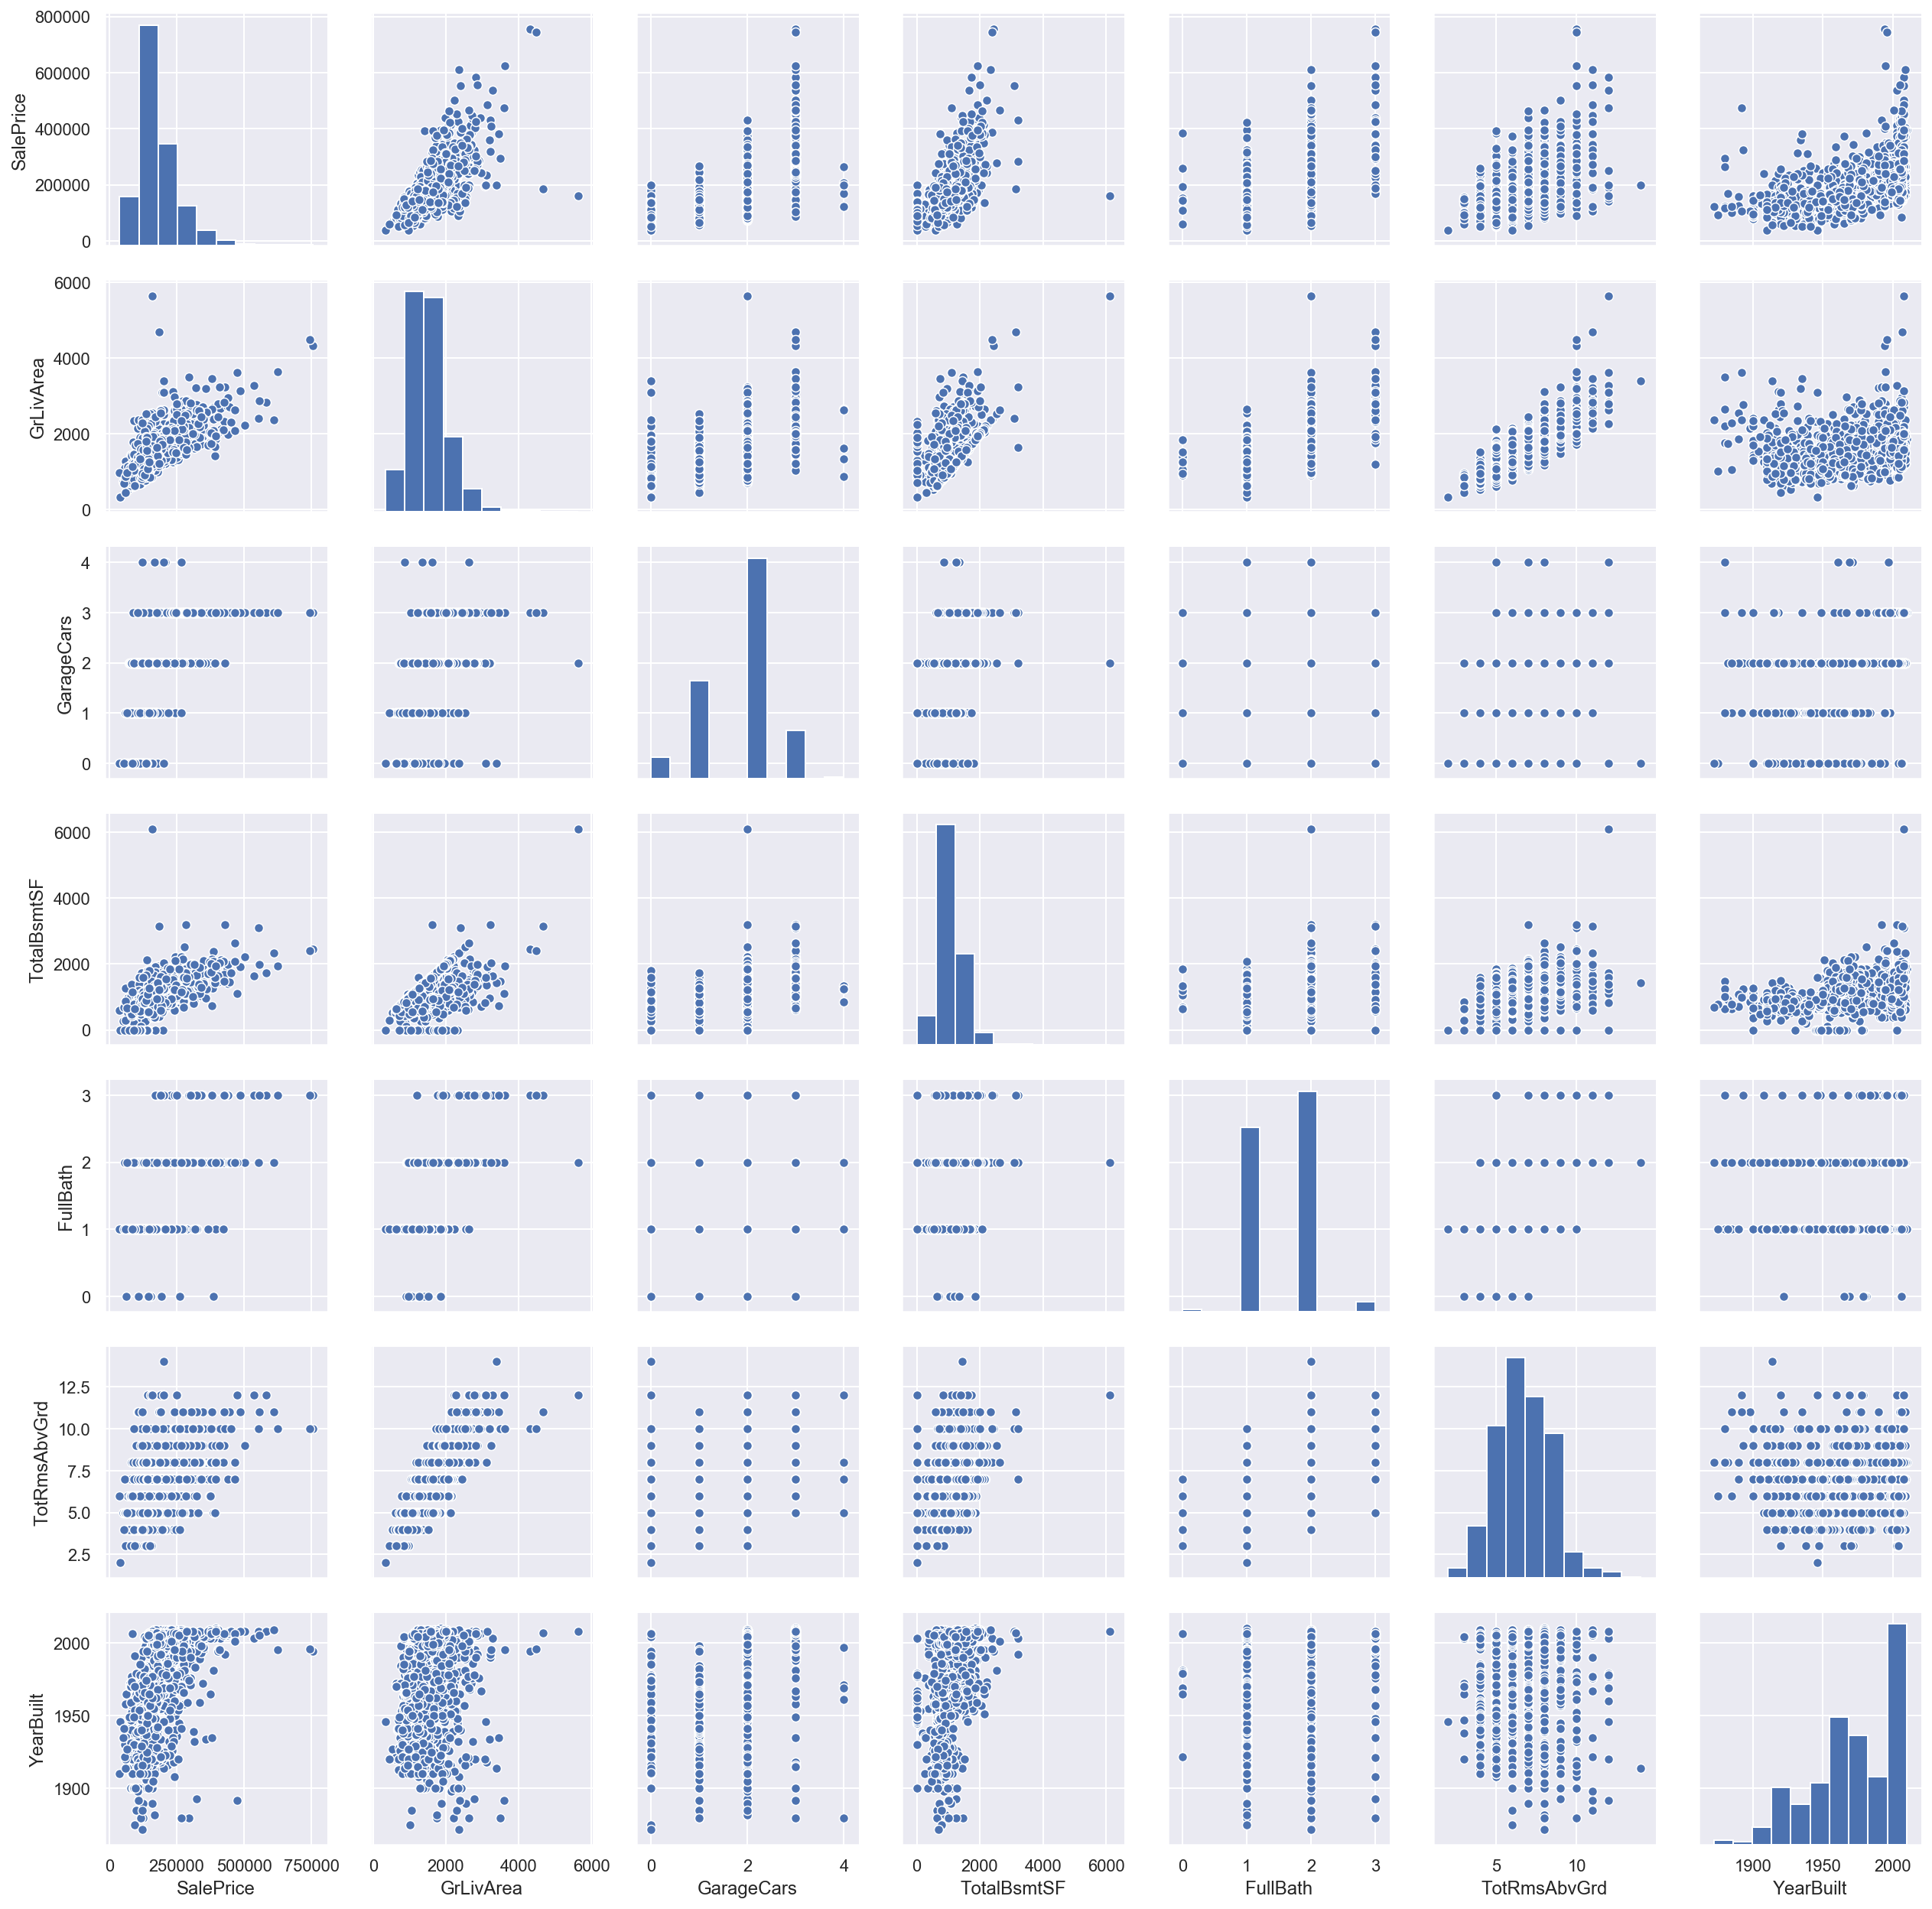

In [226]:
#pairplot SalePrice along with the top strong correlated features
sns.set()
cols = ['SalePrice', 'GrLivArea', 'GarageCars',  'TotalBsmtSF', 'FullBath','TotRmsAbvGrd','YearBuilt','Foundation', 'Neighborhood']
sns.pairplot(df1[cols], size = 2.5)
plt.show();

Dealing outliers

Look again on the SalePrice / GrLivArea relationship

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


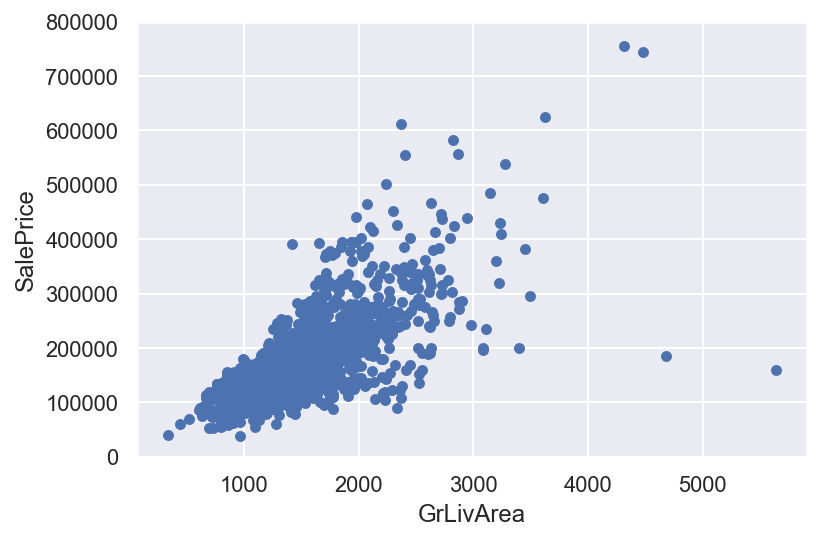

In [227]:
#scatter plot GrLivArea
var = 'GrLivArea'
saleprice_grlive = pd.concat([df1['SalePrice'], df1[var]], axis=1)
saleprice_grlive.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

The 2 points at lower right corner can be considered as outliers as they are not follow the trend

In [228]:
new_df1 = new_df1.drop(new_df1[(new_df1['GrLivArea']>4000) & (new_df1['SalePrice']<300000)].index)

Identify fixed features that can predict SalePrice using EDA

In [229]:
corr = df1_dummies.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
corr = corr.SalePrice
display(corr.head(20))

SalePrice               1.000000
SalePrice_log           0.952050
TotalSF                 0.781701
GrLivArea               0.708658
GarageCars              0.642135
TotalBsmtSF             0.612088
FullBath                0.556674
YearBuilt               0.517602
Foundation_PConc        0.494186
BsmtFinType1_GLQ        0.432266
GarageFinish_Fin        0.417753
Neighborhood_NridgHt    0.402772
BsmtFinSF1              0.384475
LotFrontage             0.352605
Neighborhood_NoRidge    0.331128
MasVnrType_Stone        0.329954
OpenPorchSF             0.329491
GarageType_Attchd       0.328630
WoodDeckSF              0.320770
BsmtExposure_Gd         0.306543
Name: SalePrice, dtype: float64

In [230]:
fixed_predictors = ['TotalSF','GrLivArea', 'GarageCars', 'TotalBsmtSF','FullBath', 'YearBuilt'
                    ,'Foundation', 'BsmtFinType1','GarageFinish','GarageType','BsmtFinSF1'
                    , 'LotFrontage', 'Neighborhood', 'OpenPorchSF', 'MasVnrArea', 'MasVnrType'
                    ,'WoodDeckSF','BsmtExposure','PavedDrive','YrSold']

In [231]:
len(fixed_predictors)

20

Train a model on pre-2010 data and evaluate its performance on the 2010 houses.



In [232]:
temp = new_df1[fixed_predictors]

In [233]:
temp.shape

(1448, 20)

In [234]:
df1_m= pd.get_dummies(temp)
print(df1_m.shape)

(1448, 73)


In [235]:
X = df1_m
y = new_df1.SalePrice_log.values

In [236]:
from sklearn.preprocessing import StandardScaler

In [237]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [238]:
df1_m.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [239]:
X_train = Xs[df1_m.YrSold.isin([2008, 2007, 2006, 2009])]
X_test = Xs[df1_m.YrSold == 2010]

# we dont standardize the target varibale

y_train = y[df1_m.YrSold.isin([2008, 2007, 2006, 2009])]
y_test = y[df1_m.YrSold == 2010]

In [240]:
X_train.shape

(1276, 73)

In [241]:
X_test.shape

(172, 73)

Modelling

I am going to test following Regression models and compare results

Ridge and Lasso

In [242]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

import matplotlib

plt.style.use('fivethirtyeight')

In [243]:
# Ridge Regression
# Find an optimal value for Ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

print(optimal_ridge.alpha_)

68.26071834272389


In [244]:
# Ridge Regression (cont)
# Cross-validate the Ridge regression R^2 with the optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.87721204 0.8675689  0.8617219  0.85918449 0.86932169 0.82081822
 0.84960641 0.85157317 0.87522506 0.86347181]
0.8595703701279975


In [245]:
# Lasso Regression
# Find an optimal value for Lasso regression alpha using LassoCV
#lasso_alphas = np.logspace(0, 5, 200)
#lasso_alphas = np.linspace(60,100,5)

optimal_lasso = LassoCV(n_alphas= 300, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0030545222309218256


.......................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


In [246]:
# Lasso Regression (cont)
# Cross-validate the Lasso R^2 with the optimal alpha.

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.88185549 0.86616138 0.86747547 0.85593978 0.86986462 0.83492998
 0.84824318 0.84881258 0.88034762 0.86087658]
0.8614506672781733


Summary: Lasso performs better than Ridge

Look at the coefficients for variables in the Ridge and Lasso

In [247]:
ridge.fit(Xs, y)

Ridge(alpha=68.26071834272389, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [248]:
ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs.head(20)

,variable,coef,abs_coef
1,GrLivArea,0.105086,0.105086
0,TotalSF,0.077341,0.077341
5,YearBuilt,0.045110,0.045110
2,GarageCars,0.043590,0.043590
42,Neighborhood_Crawfor,0.032448,0.032448
52,Neighborhood_NridgHt,0.032268,0.032268
46,Neighborhood_MeadowV,-0.027240,0.027240
6,BsmtFinSF1,0.025820,0.025820
58,Neighborhood_StoneBr,0.022361,0.022361
8,OpenPorchSF,0.021962,0.021962


In [249]:
lasso.fit(Xs, y)

Lasso(alpha=0.0030545222309218256, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [250]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
1,GrLivArea,0.102499,0.102499
0,TotalSF,0.097326,0.097326
5,YearBuilt,0.062986,0.062986
2,GarageCars,0.045284,0.045284
42,Neighborhood_Crawfor,0.035584,0.035584
52,Neighborhood_NridgHt,0.030633,0.030633
6,BsmtFinSF1,0.028862,0.028862
46,Neighborhood_MeadowV,-0.022549,0.022549
58,Neighborhood_StoneBr,0.020672,0.020672
57,Neighborhood_Somerst,0.019412,0.019412


Compare the residuals for the Ridge and Lasso visually.

In [251]:
# model residuals:

ridge_resid = y - ridge.predict(Xs)
lasso_resid = y - lasso.predict(Xs)

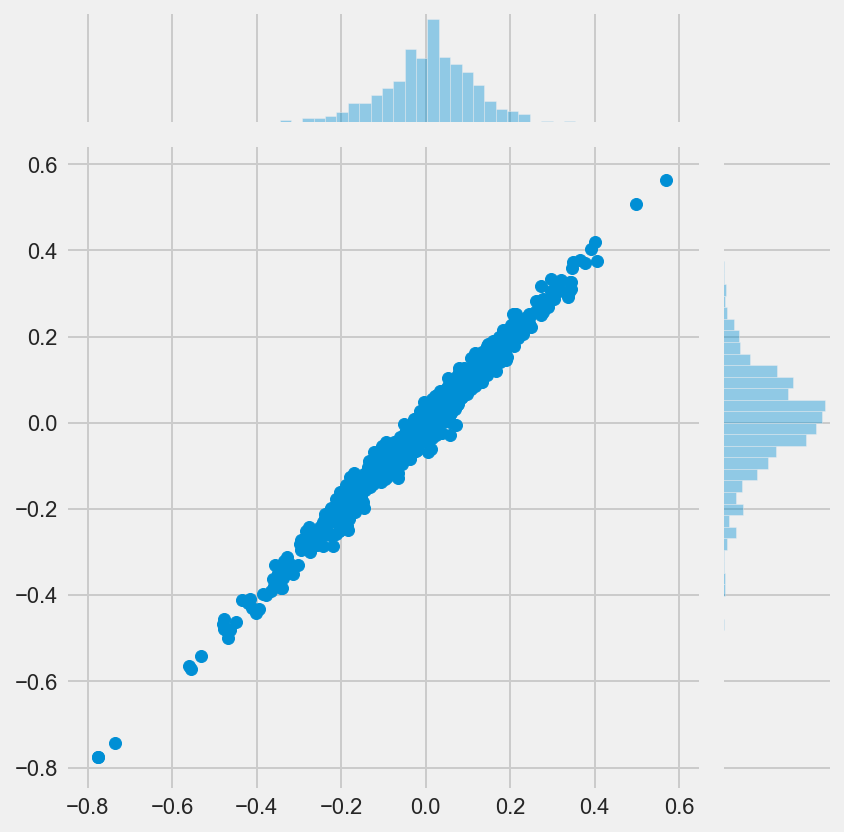

In [252]:
sns.jointplot(ridge_resid, lasso_resid)

In [253]:

ridge.score(X_train, y_train)

0.8789386974430409

In [254]:
ridge.score(X_test, y_test)

0.9039769188388562

In [255]:
lasso.score(X_train, y_train)

0.8774304205772178

In [256]:

lasso.score(X_test, y_test)

0.8999073718250146

Summary:

Both regression models performs better on the test set:
Ridge: R^2 score on the training set is 0.879 and on the test set is 0.903
Lasso: R^2 score on the training set is 0.877 and on the test set is 0.90
Based on the output, the following appear to be the best predictors of the sale price:
1. Above grade living area (GrLivArea)
2. Total square feet (TotalBsmtSF + 1stFlrSF + 2ndFlrSF)
3. Year Built (YearBuilt)
4. Size of garage in car capacity (GarageCars)
5. Physical locations within city limits (Neighborhood)
6. Basement finished square feet (BsmtFinSF1)
7. Open porch area in square feet (OpenPorchSF)


In [257]:
new_df1.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'YearBuilt', 'MasVnrType', 'MasVnrArea',
       'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'Functional', 'GarageType',
       'GarageFinish', 'GarageCars', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'MoSold', 'YrSold', 'SalePrice',
       'TotalSF', 'SalePrice_log'],
      dtype='object')

In [258]:
y_pred_saleprice = np.expm1(ridge.predict(X_test))

In [259]:
len(y_pred_saleprice)

172

In [260]:
result_df = pd.DataFrame(np.expm1(y_test), columns = ['Actual_SalePrice'])

In [261]:
result_df['Pred_SalePrice'] = y_pred_saleprice

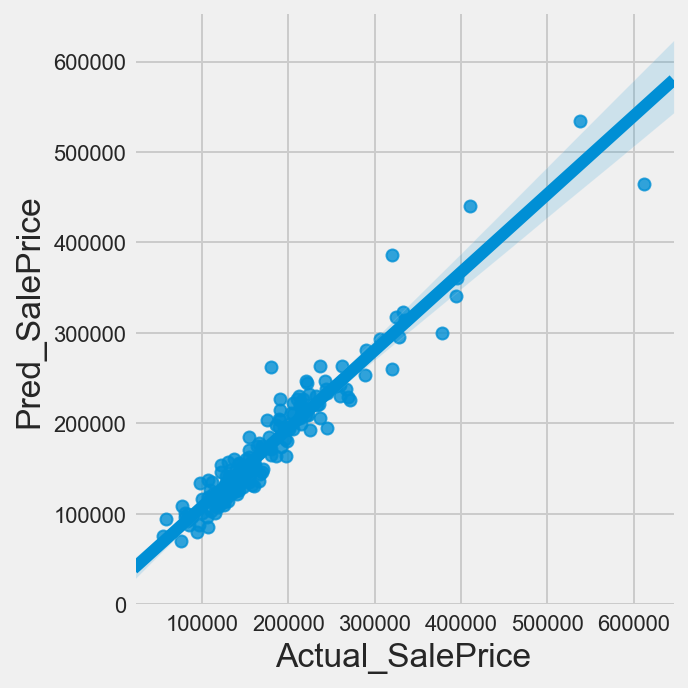

In [262]:
g = sns.lmplot(x='Actual_SalePrice', y='Pred_SalePrice', data=result_df)

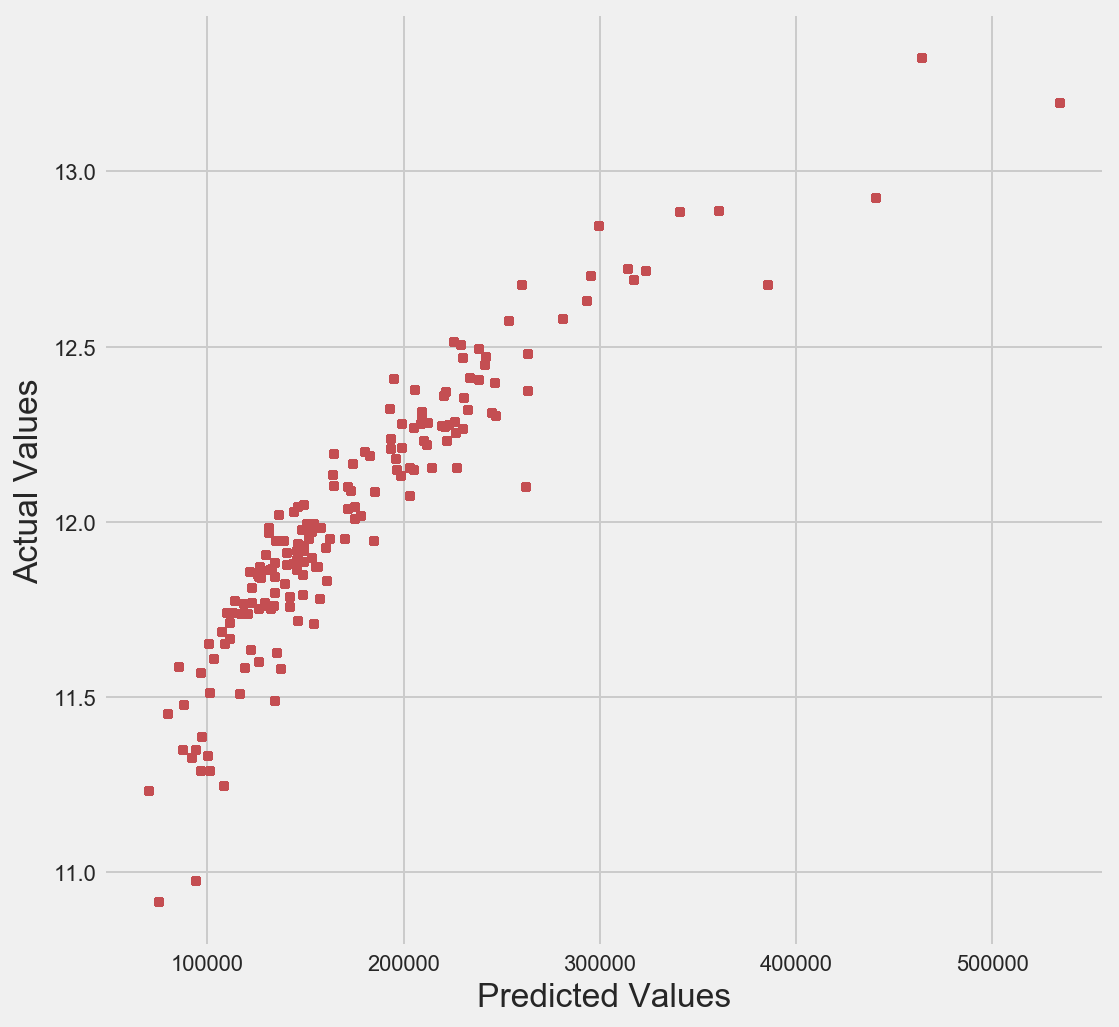

In [263]:
predictions  =  np.expm1(ridge.predict(X_test))


# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10) # plot the predicted value and the true value of target
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

#print("score: ", score)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [264]:
#list of dynamic_features

dynamic_features = ['OverallQual', 'OverallCond', 'YearRemodAdd','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 
          'Heating','HeatingQC', 'CentralAir', 'Electrical','LowQualFinSF', 'KitchenQual', 'Fireplaces', 'FireplaceQu',
         'GarageQual', 'GarageCond','BsmtQual','BsmtCond', 'Fence','PoolQC','YrSold']

In [265]:
#drop outliers
house = house.drop(house[(house['GrLivArea']>4000) & (house['SalePrice']<300000)].index)

In [266]:
df2 = house.loc[:,dynamic_features]

In [267]:
df2.shape

(1448, 24)

In [268]:
df2["Residuals"]=ridge_resid


In [269]:
df2.shape

(1448, 25)

In [270]:
df2.columns

Index(['OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual',
       'Fireplaces', 'FireplaceQu', 'GarageQual', 'GarageCond', 'BsmtQual',
       'BsmtCond', 'Fence', 'PoolQC', 'YrSold', 'Residuals'],
      dtype='object')

In [271]:
df2.head()

,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Heating,...,Fireplaces,FireplaceQu,GarageQual,GarageCond,BsmtQual,BsmtCond,Fence,PoolQC,YrSold,Residuals
0,7,5,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,GasA,...,0,NaN,TA,TA,Gd,TA,NaN,NaN,2008,0.046194
1,6,8,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,GasA,...,1,TA,TA,TA,Gd,TA,NaN,NaN,2007,-0.170878
2,7,5,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,GasA,...,1,TA,TA,TA,Gd,TA,NaN,NaN,2008,0.081448
3,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,GasA,...,1,Gd,TA,TA,TA,Gd,NaN,NaN,2006,-0.283944
4,8,5,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,GasA,...,1,TA,TA,TA,Gd,TA,NaN,NaN,2008,-0.123152


Some EDAs

In [272]:
# the above calculated residuals will the target variable and all renovate-able features will be the feature matrix

In [273]:
df2.shape

(1448, 25)

In [274]:
df2.dtypes

OverallQual       int64
OverallCond       int64
YearRemodAdd      int64
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
ExterQual        object
ExterCond        object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
LowQualFinSF      int64
KitchenQual      object
Fireplaces        int64
FireplaceQu      object
GarageQual       object
GarageCond       object
BsmtQual         object
BsmtCond         object
Fence            object
PoolQC           object
YrSold            int64
Residuals       float64
dtype: object

In [275]:
df2.isnull().sum()

OverallQual        0
OverallCond        0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
ExterQual          0
ExterCond          0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
LowQualFinSF       0
KitchenQual        0
Fireplaces         0
FireplaceQu      681
GarageQual        79
GarageCond        79
BsmtQual          37
BsmtCond          37
Fence           1170
PoolQC          1442
YrSold             0
Residuals          0
dtype: int64

Drop columns with high amounts of null values

In [276]:
df2.drop('PoolQC', axis = 1, inplace = True)
df2.drop('Fence', axis = 1, inplace = True)

In [277]:
#for each feature, print number of unique values and value / count pair
for c in list(df2.columns):
    print(c + ':' + str(df2[c].nunique()) + '\n' + str(df2[c].value_counts()))

OverallQual:10
5     396
6     373
7     319
8     168
4     111
9      43
3      18
10     16
2       2
1       2
Name: OverallQual, dtype: int64
OverallCond:9
5    817
6    250
7    204
8     72
4     54
3     24
9     22
2      4
1      1
Name: OverallCond, dtype: int64
YearRemodAdd:61
1950    171
2006     97
2007     76
2005     73
2004     62
       ... 
1982      6
1983      5
1986      5
1952      4
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64
RoofStyle:6
Gable      1135
Hip         281
Flat         13
Gambrel      10
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64
RoofMatl:7
CompShg    1423
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Roll          1
Membran       1
Name: RoofMatl, dtype: int64
Exterior1st:15
VinylSd    515
HdBoard    222
MetalSd    215
Wd Sdng    204
Plywood    107
CemntBd     60
BrkFace     49
WdShing     26
Stucco      24
AsbShng     19
BrkComm      2
Stone        2
ImStucc      1
AsphShn      1
CBlock       1
Nam

In [278]:
df2.shape

(1448, 23)

Imputing null values for other columns

In [279]:
# for columns having less than 15 null - values: replace with "none" for object columns,
# and by 0 for numerical columns 


In [280]:
# take columns with null value with temp df
cols_small_nullVals = [c for c in list(df2.columns) if (df2[c].isnull().sum() < 15)]
temp_df = df2[cols_small_nullVals]

In [281]:
temp_df.head()

,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,KitchenQual,Fireplaces,YrSold,Residuals
0,7,5,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,GasA,Ex,Y,SBrkr,0,Gd,0,2008,0.046194
1,6,8,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,GasA,Ex,Y,SBrkr,0,TA,1,2007,-0.170878
2,7,5,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,GasA,Ex,Y,SBrkr,0,Gd,1,2008,0.081448
3,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,GasA,Gd,Y,SBrkr,0,Gd,1,2006,-0.283944
4,8,5,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,GasA,Ex,Y,SBrkr,0,Gd,1,2008,-0.123152


In [282]:
#take null-value columns with object value
obj_cols = temp_df.select_dtypes('object')
num_cols = [c for c in cols_small_nullVals if c not in obj_cols]

In [283]:
print(obj_cols.columns)

Index(['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual',
       'ExterCond', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual'],
      dtype='object')


In [284]:
print(num_cols)

['OverallQual', 'OverallCond', 'YearRemodAdd', 'LowQualFinSF', 'Fireplaces', 'YrSold', 'Residuals']


In [285]:
#fill null values 

for c in list(obj_cols.columns):
    df2[c].fillna('None', inplace = True)

for c in list(num_cols):
    df2[c].fillna(0, inplace = True)

In [286]:
for c in ['FireplaceQu', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond']:
    df2[c].fillna('None', inplace = True)

In [287]:
#check for null values
df2.isnull().sum().max()

0

Remove features with low variance (low diversity of unique values) have least impact on the target variable

In [288]:
#generate a function take dataframe and column as input to calculate the diversity index of each feature

def select_feature(df, col):
    max_count = df[col].value_counts().max()
    return float(max_count)/df.shape[0]

In [289]:
feature_props = [[col, select_feature(df2, col)] for col in df2.columns]
feature_props = pd.DataFrame(feature_props, columns=['feature','majority'])
feature_props_remove_cols = feature_props[feature_props.majority > 0.95].feature.values
new_df2 = df2.drop(feature_props_remove_cols, axis=1)

In [290]:
print(feature_props_remove_cols)

['RoofMatl' 'Heating' 'LowQualFinSF']


In [291]:
new_df2.shape

(1448, 20)

Correlation matrix

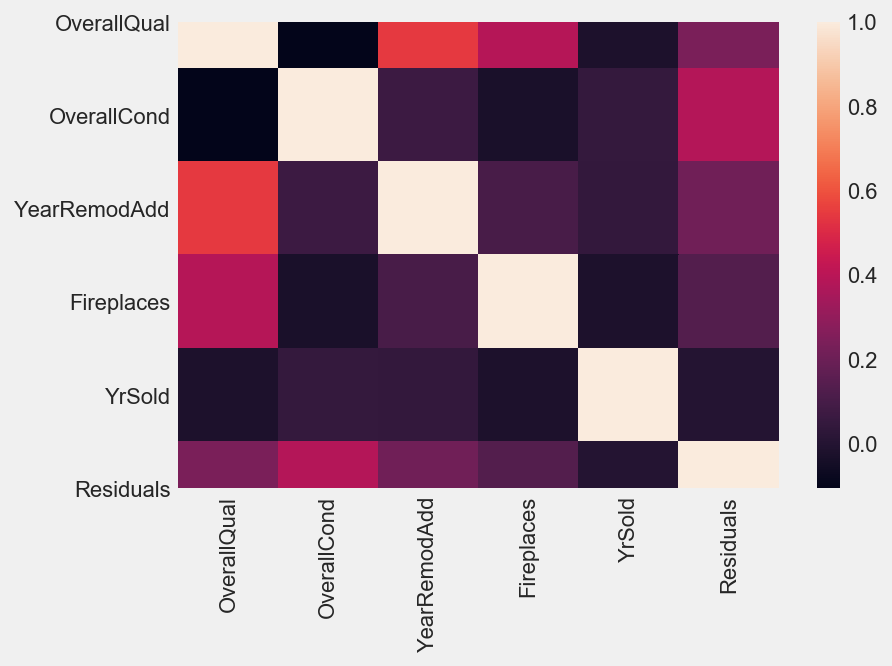

In [292]:
#use the dataframe new_df2 
corrmat = new_df2.corr()
sns.heatmap(corrmat)

In [293]:
corr= new_df2.corr()
corr.sort_values(['Residuals'], ascending=False, inplace=True)
corr = corr.Residuals
display(corr)

Residuals       1.000000
OverallCond     0.385853
OverallQual     0.236828
YearRemodAdd    0.212129
Fireplaces      0.134332
YrSold         -0.000353
Name: Residuals, dtype: float64

In [294]:
# Plotting the boxplot to see correlation of categorical features and  'Residuals'

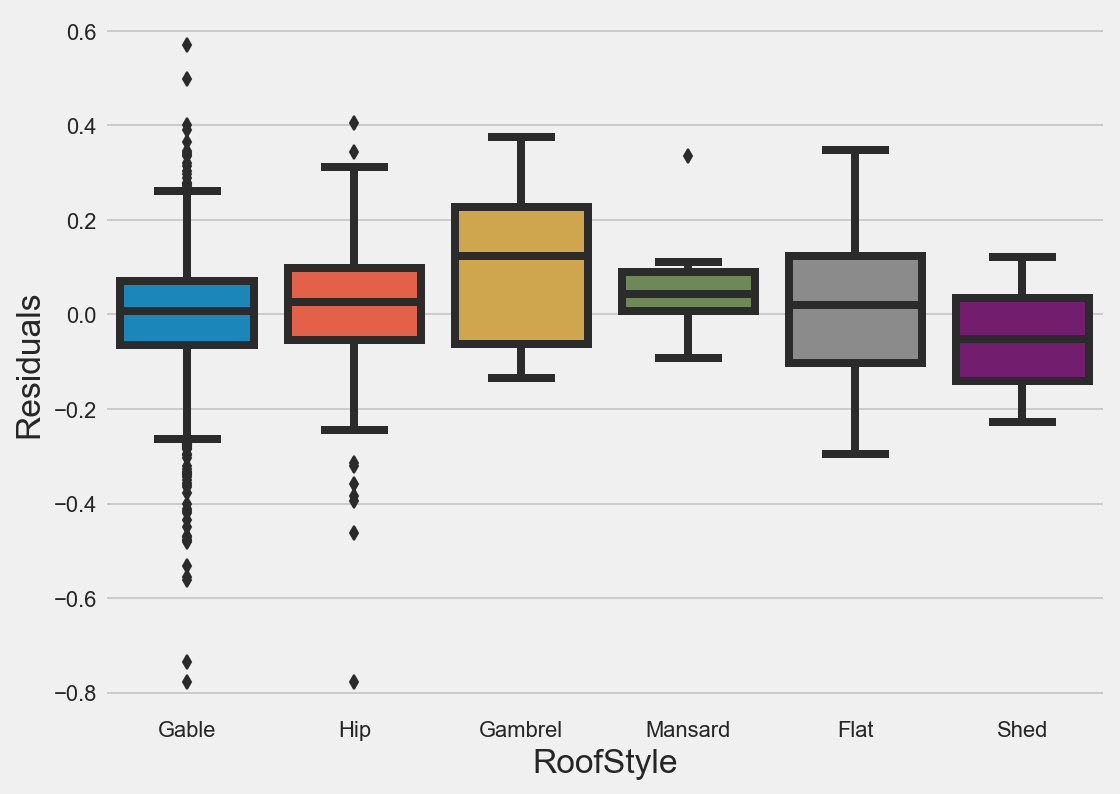

In [295]:
#box plot RoofStyle 
var = 'RoofStyle'
residuals_RoofStyle = pd.concat([new_df2['Residuals'], new_df2[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Residuals", data=residuals_RoofStyle)

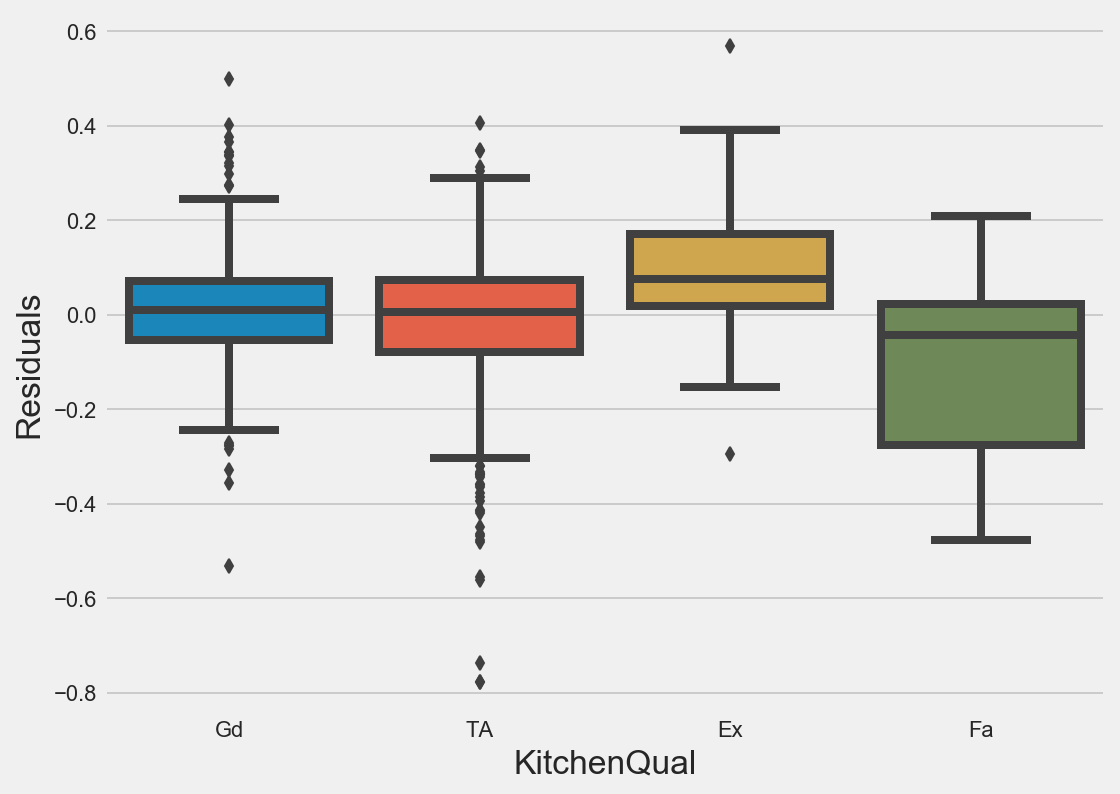

In [296]:
#box plot KitchenQual
var = 'KitchenQual'
residuals_KitchenQual = pd.concat([new_df2['Residuals'], new_df2[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Residuals", data=residuals_KitchenQual)

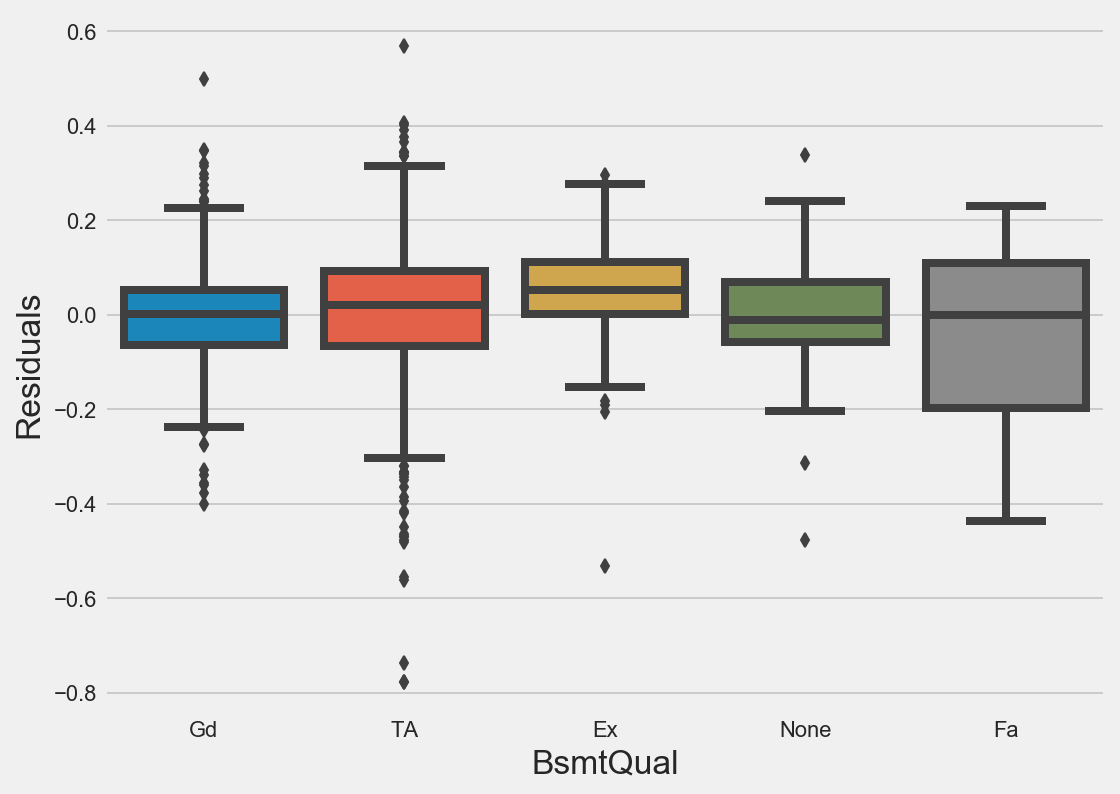

In [297]:
#box plot BsmtQual 
var = 'BsmtQual'
residuals_BsmtQual = pd.concat([new_df2['Residuals'], new_df2[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Residuals", data=residuals_BsmtQual)

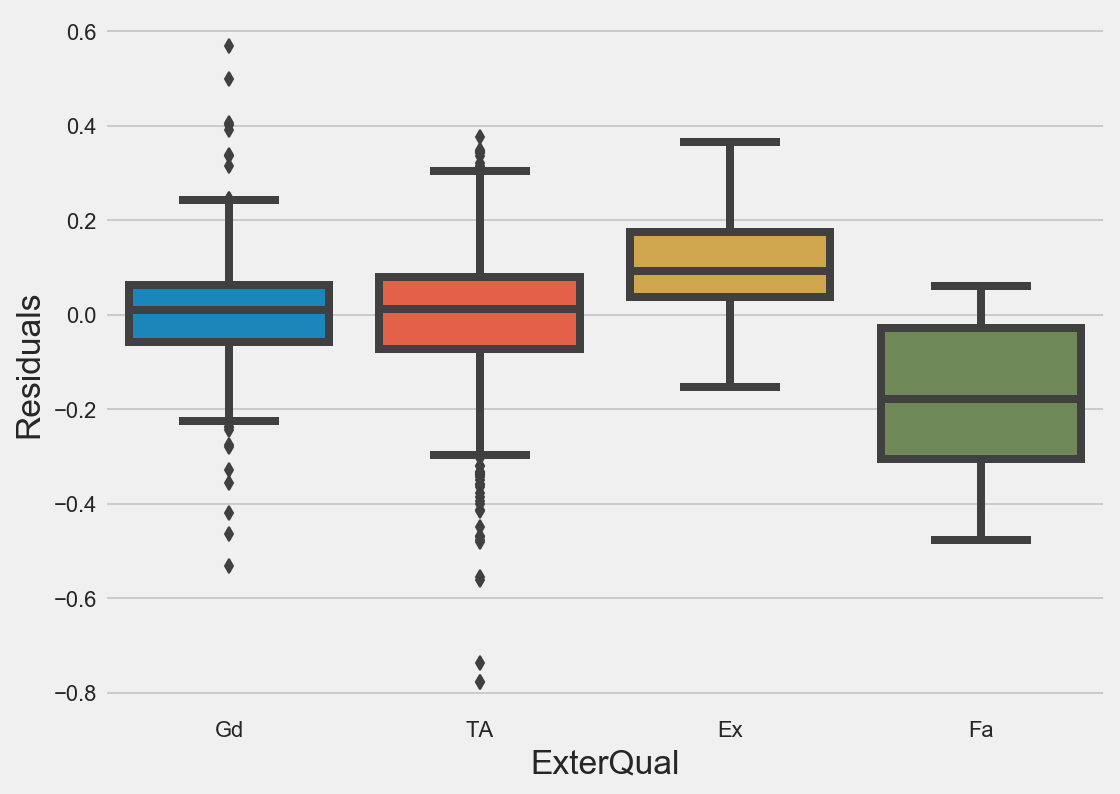

In [298]:
#box plot ExterQual 
var = 'ExterQual'
residuals_ExterQual = pd.concat([new_df2['Residuals'], new_df2[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Residuals", data=residuals_ExterQual)

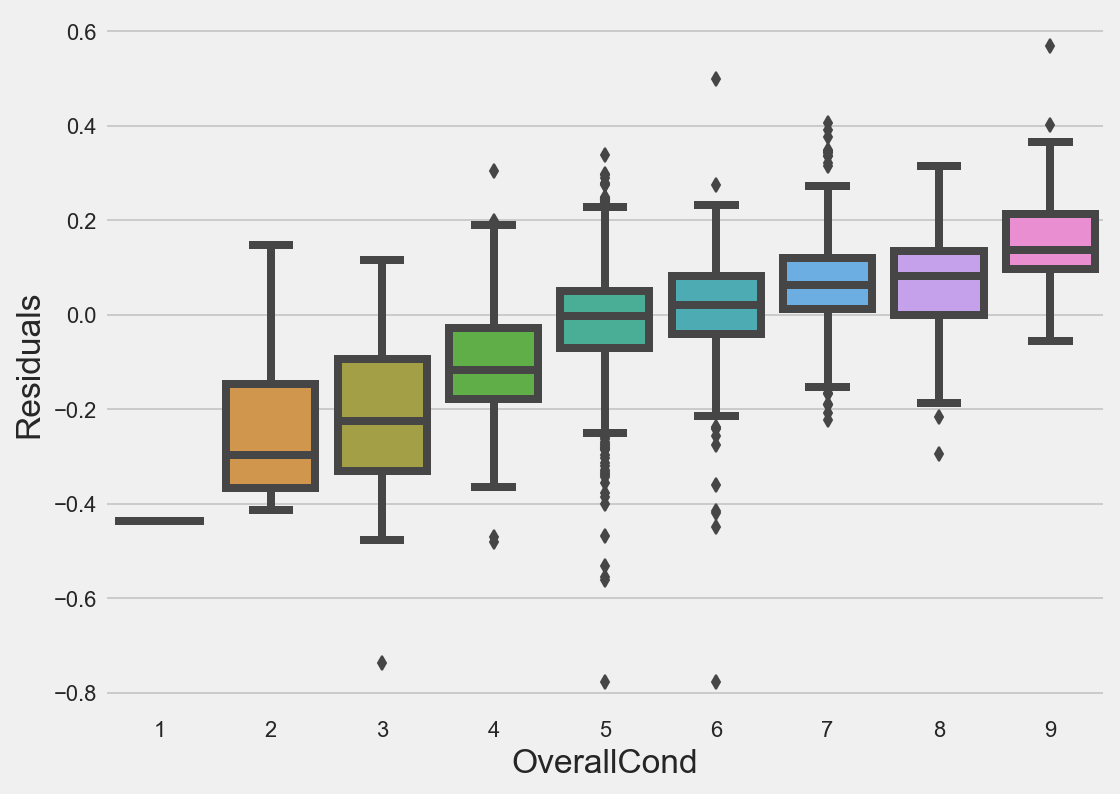

In [299]:
#box plot OverallCond 
var = 'OverallCond'
residuals_OverallCond = pd.concat([new_df2['Residuals'], new_df2[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Residuals", data=residuals_OverallCond)

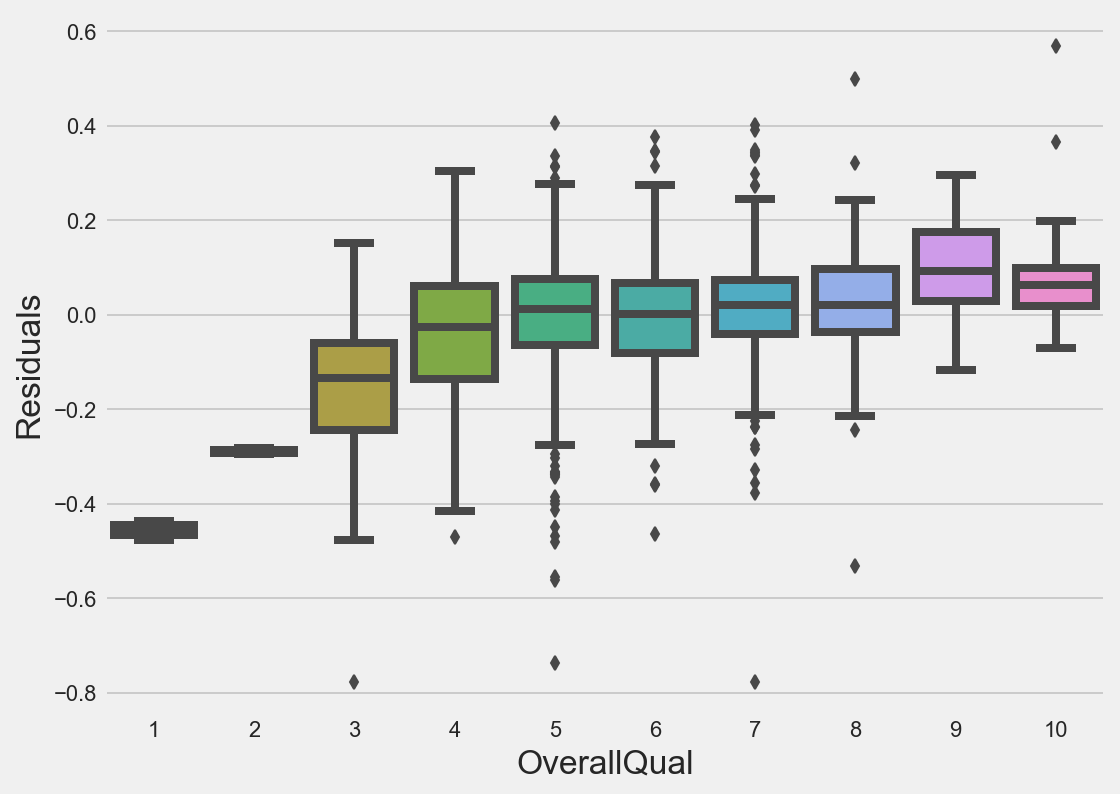

In [300]:
#box plot OverallQual 
var = 'OverallQual'
residuals_OverallQual = pd.concat([new_df2['Residuals'], new_df2[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Residuals", data=residuals_OverallQual)

In [301]:
## Convert categorical features into dummy variables

In [302]:
new_df2.shape

(1448, 20)

In [303]:
new_df2.head(3)

,OverallQual,OverallCond,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,ExterQual,ExterCond,HeatingQC,CentralAir,Electrical,KitchenQual,Fireplaces,FireplaceQu,GarageQual,GarageCond,BsmtQual,BsmtCond,YrSold,Residuals
0,7,5,2003,Gable,VinylSd,VinylSd,Gd,TA,Ex,Y,SBrkr,Gd,0,None,TA,TA,Gd,TA,2008,0.046194
1,6,8,1976,Gable,MetalSd,MetalSd,TA,TA,Ex,Y,SBrkr,TA,1,TA,TA,TA,Gd,TA,2007,-0.170878
2,7,5,2002,Gable,VinylSd,VinylSd,Gd,TA,Ex,Y,SBrkr,Gd,1,TA,TA,TA,Gd,TA,2008,0.081448


In [304]:
df2_dummies = pd.get_dummies(new_df2)
df2_dummies.shape

(1448, 97)

In [305]:
df2_dummies.head(3)

,OverallQual,OverallCond,YearRemodAdd,Fireplaces,YrSold,Residuals,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,...,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA
0,7,5,2003,0,2008,0.046194,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,6,8,1976,1,2007,-0.170878,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,7,5,2002,1,2008,0.081448,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


In [306]:
corr2 = df2_dummies.corr()
corr2.sort_values(['Residuals'], ascending=False, inplace=True)
corr2 = corr2.Residuals
display(corr2.head(40))

Residuals              1.000000
OverallCond            0.385853
OverallQual            0.236828
YearRemodAdd           0.212129
CentralAir_Y           0.206520
KitchenQual_Ex         0.182361
ExterQual_Ex           0.145949
HeatingQC_Ex           0.141513
Fireplaces             0.134332
FireplaceQu_Gd         0.132845
ExterCond_Ex           0.115120
BsmtQual_Ex            0.111836
Exterior1st_BrkFace    0.101673
GarageQual_Ex          0.091887
Electrical_SBrkr       0.081312
ExterCond_Gd           0.073134
RoofStyle_Gambrel      0.069059
GarageQual_Gd          0.061547
RoofStyle_Hip          0.060570
Exterior2nd_CmentBd    0.060175
KitchenQual_Gd         0.059977
Exterior2nd_BrkFace    0.058675
Exterior1st_CemntBd    0.056372
BsmtCond_Gd            0.055935
FireplaceQu_Ex         0.052934
GarageCond_TA          0.051129
BsmtCond_TA            0.050887
Exterior1st_Stucco     0.045127
RoofStyle_Mansard      0.035752
Exterior2nd_Wd Sdng    0.034733
GarageCond_Ex          0.033893
ExterQua

Building regression models (regularizarion):
1. Ridges
2. Lasso

In [307]:
y2 = df2_dummies.Residuals.values
df2_dummies.drop('Residuals', axis = 1, inplace = True)
X2 = df2_dummies

In [308]:
X2.shape

(1448, 96)

In [309]:
ss2 = StandardScaler()
Xs2 = ss2.fit_transform(X2)

X2_train = Xs2[new_df2.YrSold.isin([2008, 2007, 2006, 2009])]
X2_test = Xs2[new_df2.YrSold == 2010]

# we dont standardize the target varibale

y2_train = y2[new_df2.YrSold.isin([2008, 2007, 2006, 2009])]
y2_test = y2[new_df2.YrSold == 2010]



In [310]:
display(X2_train.shape)
display(X2_test.shape)

(1276, 96)

(172, 96)

In [311]:
display(y2_train.shape)
display(y2_test.shape)

(1276,)

(172,)

In [312]:
# do Ridge Regression
# Find an optimal value for Ridge regression alpha using RidgeCV
ridge_alphas_2 = np.logspace(0, 5, 200)

optimal_ridge_2 = RidgeCV(alphas=ridge_alphas_2, cv=10)
optimal_ridge_2.fit(X2_train, y2_train)

print(optimal_ridge_2.alpha_)

307.21129988617594


In [313]:
# Ridge Regression (cont)
# Cross-validate the Ridge regression R^2 with the optimal alpha
ridge_2 = Ridge(alpha=optimal_ridge_2.alpha_)

ridge_scores_2 = cross_val_score(ridge_2, X2_train, y2_train, cv=10)

print(ridge_scores_2)
print(np.mean(ridge_scores_2))


[0.12699261 0.28031824 0.28844526 0.27400023 0.12666517 0.20690784
 0.02902661 0.35282932 0.27526295 0.18236053]
0.214280876963451


In [314]:
# Lasso Regression
# Find an optimal value for Lasso regression alpha using LassoCV

optimal_lasso_2 = LassoCV(n_alphas=300, cv=10, verbose=1)
optimal_lasso_2.fit(X2_train, y2_train)

print(optimal_lasso_2.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0044398132638656706


...................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


In [315]:
# Lasso Regression (cont)
# cross-validation for model

lasso_2 = Lasso(alpha=optimal_lasso_2.alpha_)

lasso_scores_2 = cross_val_score(lasso_2, X2_train, y2_train, cv=10)

print(lasso_scores_2)
print(np.mean(lasso_scores_2))

[ 0.10369838  0.32687106  0.36883283  0.29274605  0.14444693  0.22658462
 -0.00896106  0.32794995  0.29868412  0.21853006]
0.2299382942381106


Based on the cross - validation score, Lasso model perform better than Ridge model

Review the slope coefficients for variables in the Ridge and Lasso models

In [316]:
#coefficients for Ridge model
ridge_2.fit(X2_train,y2_train)
ridge_coefs_2 = pd.DataFrame({'variable':X2.columns,
                              'coef':ridge_2.coef_,
                              'abs_coef':np.abs(ridge_2.coef_)})

ridge_coefs_2.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs_2.head(10)

,variable,coef,abs_coef
1,OverallCond,0.039182,0.039182
0,OverallQual,0.019223,0.019223
2,YearRemodAdd,0.012026,0.012026
14,Exterior1st_BrkFace,0.010884,0.010884
74,GarageQual_Ex,0.008683,0.008683
13,Exterior1st_BrkComm,-0.008532,0.008532
64,KitchenQual_Ex,0.008364,0.008364
56,CentralAir_N,-0.007195,0.007195
57,CentralAir_Y,0.007195,0.007195
89,BsmtQual_None,0.006657,0.006657


In [317]:
#coefficients for Lasso models
lasso_2.fit(X2_train,y2_train)
lasso_coefs_2 = pd.DataFrame({'variable':X2.columns,
                              'coef':lasso_2.coef_,
                              'abs_coef':np.abs(lasso_2.coef_)})

lasso_coefs_2.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs_2.head(10)

,variable,coef,abs_coef
1,OverallCond,0.050419,0.050419
0,OverallQual,0.023371,0.023371
56,CentralAir_N,-0.011075,0.011075
89,BsmtQual_None,0.010669,0.010669
14,Exterior1st_BrkFace,0.010309,0.010309
64,KitchenQual_Ex,0.008787,0.008787
13,Exterior1st_BrkComm,-0.005277,0.005277
77,GarageQual_None,0.004789,0.004789
74,GarageQual_Ex,0.004435,0.004435
2,YearRemodAdd,0.004051,0.004051


In [318]:
# model residuals:
ridge_resid_2 = y2 - ridge_2.predict(Xs2)
lasso_resid_2 = y2 - lasso_2.predict(Xs2)

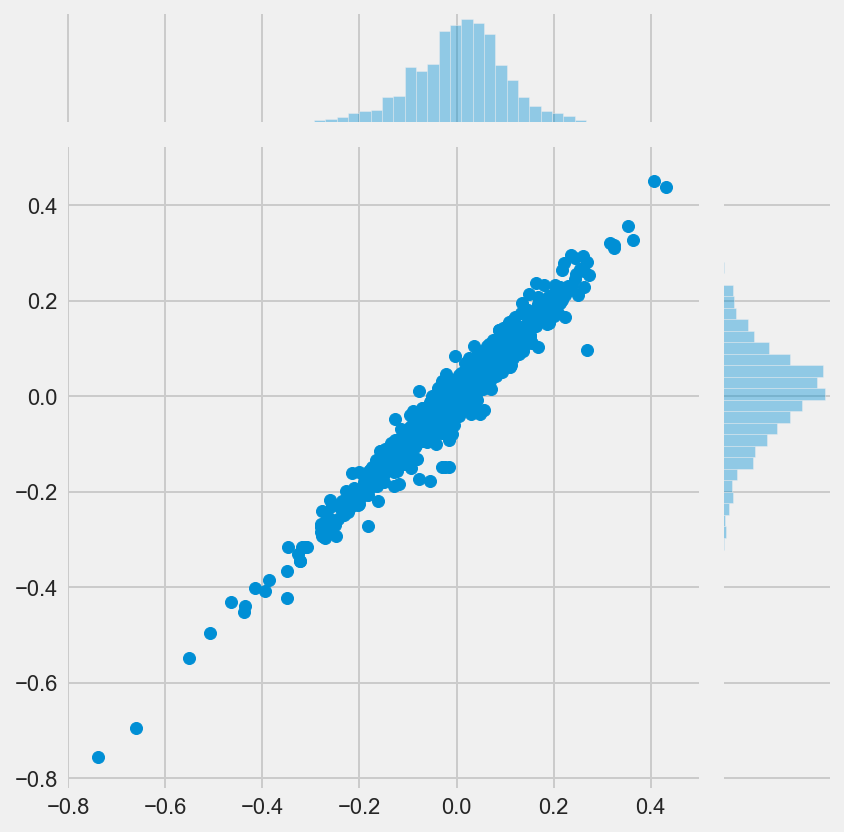

In [319]:
#plot
sns.jointplot(ridge_resid_2, lasso_resid_2)

In [320]:
#calculate R2 scores of 2 Ridge and lasso models

In [321]:
ridge_2.score(X2_train,y2_train)

0.3293116212807947

In [322]:
ridge_2.score(X2_test,y2_test)

0.13129531597013755

In [323]:
lasso_2.score(X2_train,y2_train)

0.29802590337789436

In [324]:
lasso_2.score(X2_test,y2_test)

0.16588631339301518

Evaluate the effect in dollars of the renovatable features

In [325]:
pred_residuals = ridge_2.predict(Xs2)
pred_saleprice2 = np.round(np.expm1(new_df1.SalePrice_log - pred_residuals))
print(pred_saleprice2)


0       213359.0
1       164673.0
2       226342.0
3       141749.0
4       249933.0
          ...   
1455    177310.0
1456    212074.0
1457    221340.0
1458    138343.0
1459    153285.0
Name: SalePrice_log, Length: 1448, dtype: float64


In [326]:
df2["Predicted_SalePrice_DynamicFeats"]=pred_saleprice2
df2.head(3)

,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Heating,...,KitchenQual,Fireplaces,FireplaceQu,GarageQual,GarageCond,BsmtQual,BsmtCond,YrSold,Residuals,Predicted_SalePrice_DynamicFeats
0,7,5,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,GasA,...,Gd,0,None,TA,TA,Gd,TA,2008,0.046194,213359.0
1,6,8,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,GasA,...,TA,1,TA,TA,TA,Gd,TA,2007,-0.170878,164673.0
2,7,5,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,GasA,...,Gd,1,TA,TA,TA,Gd,TA,2008,0.081448,226342.0


Evaluate the coefficients of models can effect the buying decision of property or not?

based on the model output, the following renovable features are better to use to predict the house price

1. Overall condition
2. Overall quality
3. Remodel date (YearRemodAdd)
4. Exterior covering on house (Exterior1st)
5. Garage quality
6. Kitchen qual
7. Having central air conditioning (CentralAir)
8. Bsmt quality

Investigate how much of the variance in price remaining is explained by these features. Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

As the Lasso score is 0.2299, this mean that, in our model, nearly 23% of the variance in price unexplained by the fixed characteristics can be explained by the easy-to-change aspects of the property.

In [327]:
y2_pred =lasso_2.predict(X2_test)

In [328]:
from sklearn import metrics
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y2_test, y2_pred))) 

Root Mean Squared Error: 0.11134471411846192


RMSE measures the standard deviation of the residuals (or how spread out these residuals are). Lower values of RMSE indicate better fit. As the RMSE of our model is 0.11 which is quite small, I can say that our model can be trusted.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [329]:
# A: